## Deep Learning Portfolio Strategy - Dynamic Sharpe Ratios Minimization

### Introduction
In this exercise, I explored the use of MLP, LSTM and ConvNet (1D and 2D) to predict the 20-day ahead cumulative returns of TIP and GLD as a dynamic bi-variate Normal distribution. The reason for modeling the returns indirectly through a probability distribution is two-fold. First, asset returns can present auto-regressive, regime-switching and volatility clustering properties, which can be modeled as a dynamic probability distribution such as Normal. Second, the modeled latent returns and covariances enable a multi-asset portfolio strategy that dynamically minimizes the Sharpe ratios. It also has the benefit of modeling the uncertainty around the best estimated prediction.

I used the daily close price data of TIP and GLD from Finance Yahoo between 2000/01/01 and 2025/09/05. The daily prices were converted to daily simple returns, which serve as the features. The 20-day aheadcumulative returns were calculated, which serve as the targets.

The report below starts with Data and EDA in section 1, followed by 4 models - MLP, LSTM, CNN (2D) and CNN (1D) in section 2-5. with out-of-sample performances. The multi-asset portfolio strategy that dynamically minimizes the Sharpe ratios based on the means, volatilities and correlations from the 4 models is back-tested and compared to the buy-and-hold strategy in section 6. Based on the back-testing results, the portfolio strategy appear to slightly outperform the buy-and-hold strategy on both Sharpe ratios and cumulative return.

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyts.image import GramianAngularField
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal, StudentT
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

### 1 Data and EDA
The raw data contains the daily close price of TIP and GLD between 2000/01/01 and 2025/09/05, a total of more than 5000 data points. The price data is transformed to daily return data as features and 20-day ahead cumulative returns as target variables.

This is followed by EDA and training/testing data processing for PyTorch modeling based on the walk forward approach.

#### 1.1 Data ETL
We loaded the daily close price of TIP and GLD using *yf* package. Based on the raw daily price data simple daily returns were calculated as features. The target variables were calculated as the 20-day ahead cumulative returns.

In [ ]:
tickers = [ 'GLD', 'TIP']
start_date = '2000-01-01'
end_date = '2025-09-05'

data = {}
for ticker in tickers:
    df_ticker = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, back_adjust=False)[['Close']]
    data[ticker] = df_ticker

df = pd.concat(data, axis=1)
df.columns = tickers

# Calculate daily return
df = df.pct_change().dropna()

for ticker in df.columns:
    df_ticker = df[ticker].copy()

    # Add 10-day ahead cumulative return
    df[f'{ticker}_20d'] = df_ticker.rolling(10).apply(lambda x: np.prod(x + 1) - 1).shift(-10)

df.dropna(inplace=True)
df.info()
display(df.head())
display(df.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5220 entries, 2004-11-19 to 2025-08-20
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GLD      5220 non-null   float64
 1   TIP      5220 non-null   float64
 2   GLD_20d  5220 non-null   float64
 3   TIP_20d  5220 non-null   float64
dtypes: float64(4)
memory usage: 203.9 KB


,GLD,TIP,GLD_20d,TIP_20d
Date,,,,
2004-11-19,0.009013,-0.002746,0.008709,-0.000475
2004-11-22,0.003796,0.004463,0.003560,-0.004538
2004-11-23,-0.004449,-0.001891,-0.016536,0.004168
2004-11-24,0.006704,0.002652,-0.028191,-0.000850
2004-11-26,0.005327,-0.003968,-0.040848,0.001612


,GLD,TIP,GLD_20d,TIP_20d
Date,,,,
2025-08-14,-0.006339,-0.002984,0.025321,0.009433
2025-08-15,0.000586,-0.001905,0.034610,0.010269
2025-08-18,-0.001561,-0.001091,0.060726,0.005731
2025-08-19,-0.005473,0.001001,0.074917,0.006998
2025-08-20,0.010122,0.001091,0.059444,0.007444


#### 1.2 EDA
The EDA performed on the daily returns and 20-day cumulative returns were performed below:
1. the probability distribution is roughly symmetrically distributed, with heavy tails and volatility clustering.
2. The 100-day rolling means and volatilities vary over time.
2. The correlation between the two assets seem to be strongly positive and varying over time.
3. All variables are stationary based on the ADFuller test.

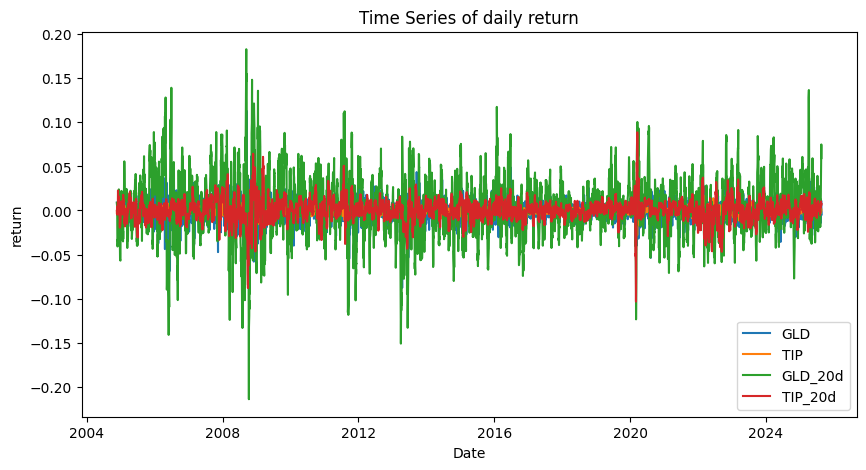

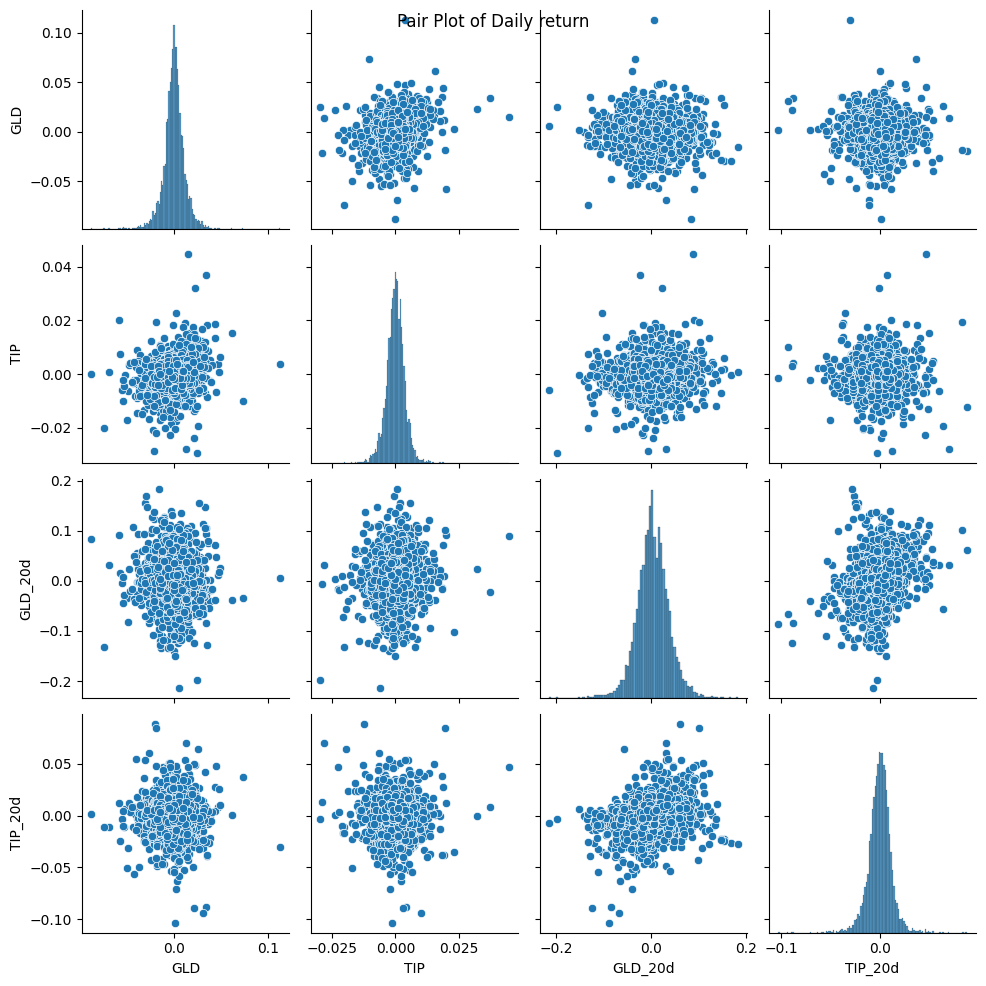

In [ ]:
plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot(df.index, df[col], label=col[0:8]) # Use the ticker name as label
plt.title('Time Series of daily return')
plt.xlabel('Date')
plt.ylabel('return')
plt.legend()
plt.show()

sns.pairplot(df)
plt.suptitle('Pair Plot of Daily return')
plt.show()

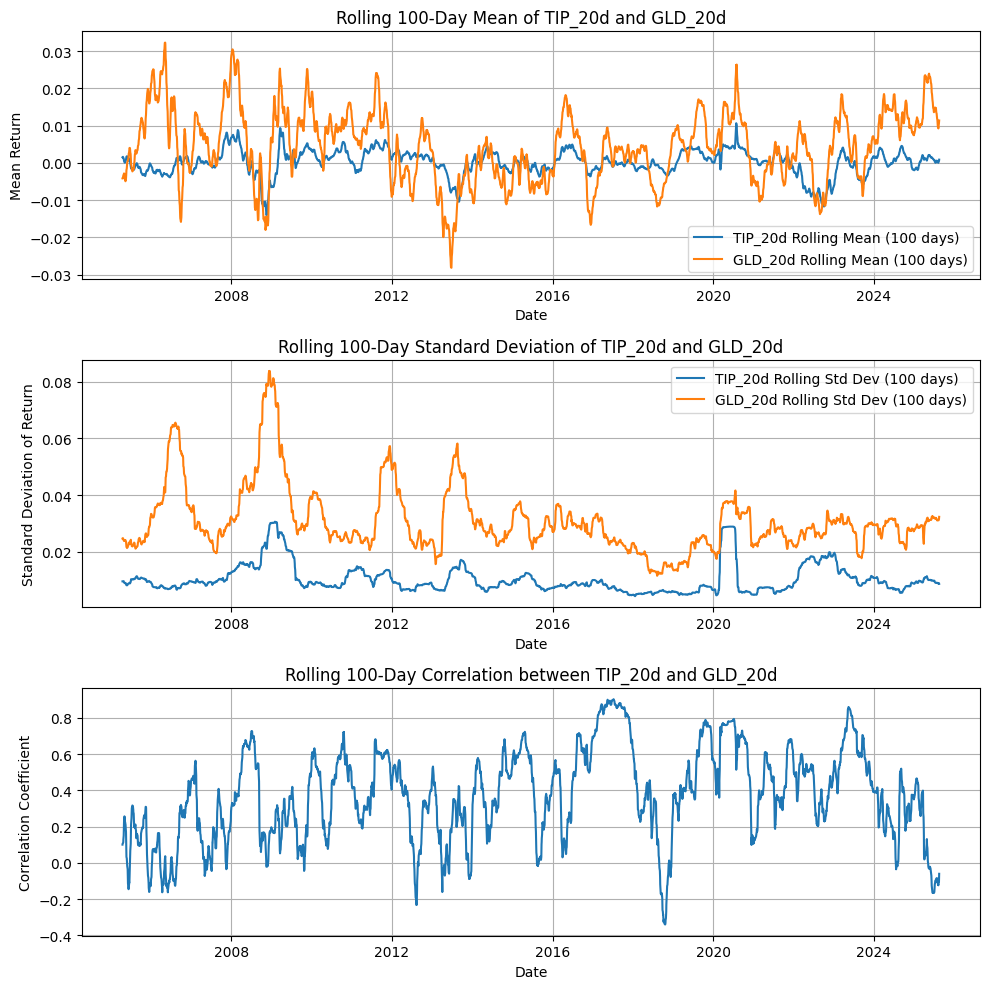

In [ ]:
# Calculate rolling 100-day mean and std for 'TIP' and 'GLD' and the correlation coefficient
rolling_mean_tip = df['TIP_20d'].rolling(window=100).mean()
rolling_mean_gld = df['GLD_20d'].rolling(window=100).mean()
rolling_std_tip = df['TIP_20d'].rolling(window=100).std()
rolling_std_gld = df['GLD_20d'].rolling(window=100).std()
rolling_correlation = df['TIP_20d'].rolling(window=100).corr(df['GLD_20d'])

# Plot Rolling mean, std, and correlation
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
axes[0].plot(rolling_mean_tip.index, rolling_mean_tip, label='TIP_20d Rolling Mean (100 days)')
axes[0].plot(rolling_mean_gld.index, rolling_mean_gld, label='GLD_20d Rolling Mean (100 days)')
axes[0].set_title('Rolling 100-Day Mean of TIP_20d and GLD_20d')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Mean Return')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(rolling_std_tip.index, rolling_std_tip, label='TIP_20d Rolling Std Dev (100 days)')
axes[1].plot(rolling_std_gld.index, rolling_std_gld, label='GLD_20d Rolling Std Dev (100 days)')
axes[1].set_title('Rolling 100-Day Standard Deviation of TIP_20d and GLD_20d')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Standard Deviation of Return')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(rolling_correlation.index, rolling_correlation)
axes[2].set_title('Rolling 100-Day Correlation between TIP_20d and GLD_20d')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Correlation Coefficient')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Perform ADF tests
print("ADF Test Results for Daily Returns:")
for col in df.columns:
    adf_result = adfuller(df[col].dropna())
    print(f"{col}:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"P-value: {adf_result[1]:.4f}")
    if adf_result[1] <= 0.05:
        print(f"{col} data is stationary")
    else:
        print(f"{col} data is non-stationary")
    print("-" * 20)

ADF Test Results for Daily Returns:
GLD:
ADF Statistic: -73.1515
P-value: 0.0000
GLD data is stationary
--------------------
TIP:
ADF Statistic: -26.1895
P-value: 0.0000
TIP data is stationary
--------------------
GLD_20d:
ADF Statistic: -11.5333
P-value: 0.0000
GLD_20d data is stationary
--------------------
TIP_20d:
ADF Statistic: -10.7965
P-value: 0.0000
TIP_20d data is stationary
--------------------


#### 1.3 Preparing Training and Testing data
We prepared the typical time series data and the GAF (Gramian Angular Field) image data, both with a sliding window of previous 40 days.

The whole dataset is split into training and testing data based on the non-anchored walk forward approach with purging and embargo.

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.y) - self.seq_len + 1

    def __getitem__(self, idx):
        X = self.X[idx:idx+self.seq_len]

        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(self.y[idx+self.seq_len-1], dtype=torch.float32)
        )

In [ ]:
# Gramian Angular field transform
class GAFTimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=30, method='summation'):
        """
        Args:
          X: numpy array (T, n_features)
          y: numpy array (T, targets)
          seq_len: input sequence length
          method: 'summation' or 'difference' GAF type
        """
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.method = method
        self.gaf = GramianAngularField(image_size=seq_len, method=self.method)

        self.length = len(y) - seq_len + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        seq = self.X[idx:idx+self.seq_len]
        # Min-max scale each feature in sequence independently to [0,1] for GAF
        seq_scaled = (seq - np.min(seq, axis=0)) / (np.ptp(seq, axis=0) + 1e-8)

        # pyts expects shape (n_samples, n_timestamps), so transpose each sample for features
        gaf_images = self.gaf.transform(seq_scaled.T)  # shape (n_features, image_size, image_size)

        # Convert to torch tensor, shape (channels, H, W)
        gaf_tensor = torch.tensor(gaf_images, dtype=torch.float32)
        target = torch.tensor(self.y[idx+self.seq_len-1], dtype=torch.float32)

        return gaf_tensor, target

In [ ]:
def walkforward_loaders(X, y, n_train, n_test, seq_len=30, purge=0, embargo=0, batch_size=32, dataset_type='TimeSeriesDataset'):
    """
    X, y: np.arrays of shape (T, features) and (T, outputs)
    Generates walk-forward train/test DataLoaders with purging and embargo
    """
    datasets = []
    fold_num = 0
    i = 0
    while i + n_train + n_test <= len(y):
        train_start = i
        train_end = i + n_train

        test_start = train_end + purge
        test_end = test_start + n_test

        if test_end > len(y):
            break

        # Slice training data
        X_train = X[train_start:train_end]
        y_train = y[train_start:train_end]

        # Slice testing data
        X_test = X[test_start:test_end]
        y_test = y[test_start:test_end]

        # Create Datasets based on dataset_type
        if dataset_type == 'TimeSeriesDataset':
            train_dataset = TimeSeriesDataset(X_train, y_train, seq_len)
            test_dataset = TimeSeriesDataset(X_test, y_test, seq_len)
        elif dataset_type == 'GAFTimeSeriesDataset':
            train_dataset = GAFTimeSeriesDataset(X_train, y_train, seq_len)
            test_dataset = GAFTimeSeriesDataset(X_test, y_test, seq_len)
        else:
            raise ValueError("Invalid dataset_type. Choose 'TimeSeriesDataset' or 'GAFTimeSeriesDataset'.")

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        print(
            f"Fold {fold_num}: Train [{train_start}:{train_end}] Test [{test_start}:{test_end}], "
            f"Train shape {X_train.shape}, Test shape {X_test.shape}"
        )

        datasets.append((train_loader, test_loader))

        fold_num += 1
        i = test_end + embargo  # advance index respecting embargo

    return datasets

In [ ]:
X = df[['TIP', 'GLD']].values
y = df[['TIP_20d', 'GLD_20d']].values
n_train=4000
n_test=1200
seq_len=40
purge=0
embargo=0
batch_size=32

In [ ]:
dataloaders = walkforward_loaders(
    X, y,
    n_train=n_train,
    n_test=n_test,
    seq_len=seq_len,
    purge=purge,
    embargo=embargo,
    batch_size=batch_size)

# Get the first batch from the first training dataloader
first_train_loader, _ = dataloaders[0]
first_batch_X, first_batch_y = next(iter(first_train_loader))

# Print the shape of the input tensor in the batch
print(f"Shape of a single input batch (X): {first_batch_X.shape}")
print(f"Shape of a single target batch (y): {first_batch_y.shape}")

Fold 0: Train [0:4000] Test [4000:5200], Train shape (4000, 2), Test shape (1200, 2)
Shape of a single input batch (X): torch.Size([32, 40, 2])
Shape of a single target batch (y): torch.Size([32, 2])


Fold 0: Train [0:4000] Test [4000:5200], Train shape (4000, 2), Test shape (1200, 2)
Shape of a single input batch (X) from GAF dataloader: torch.Size([32, 2, 40, 40])
Shape of a single target batch (y) from GAF dataloader: torch.Size([32, 2])


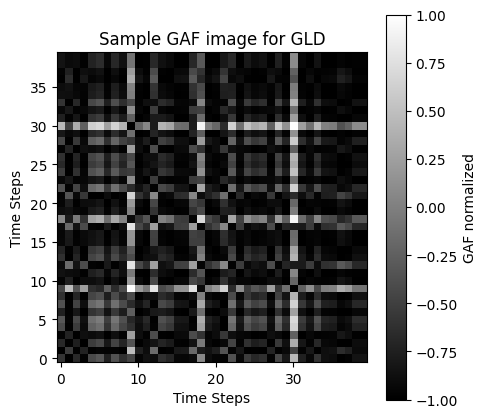

In [ ]:
# Generate GAF dataloaders
gaf_dataloaders = walkforward_loaders(
    X, y,
    n_train=n_train,
    n_test=n_test,
    seq_len=seq_len,
    purge=purge,
    embargo=embargo,
    batch_size=batch_size,
    dataset_type='GAFTimeSeriesDataset' # Specify the dataset type
)

# Get the first batch from the first training dataloader
first_gaf_train_loader, _ = gaf_dataloaders[0]
first_batch_X_gaf, first_batch_y_gaf = next(iter(first_gaf_train_loader))

# Print the shape of the input tensor in the batch
print(f"Shape of a single input batch (X) from GAF dataloader: {first_batch_X_gaf.shape}")
print(f"Shape of a single target batch (y) from GAF dataloader: {first_batch_y_gaf.shape}")

# Get a sample from the dataset within this cell
gaf_images, target = first_gaf_train_loader.dataset[0]
# Plot the first feature of the first sample
plt.figure(figsize=(5, 5))
plt.imshow(gaf_images[0].numpy(), cmap='gray', origin='lower')
plt.title('Sample GAF image for GLD')
plt.xlabel('Time Steps')
plt.ylabel('Time Steps')
plt.colorbar(label='GAF normalized')
plt.show()

### 2 MLP Model and Results
The first model is a MLP neural networks with 2 hidden layers with ReLU activation and dropouts, and an output layer containing 5 variables - the means, the volatilities and the correlation coefficient betwen the two assets. These 5 output variables are used as the parameters of a dynamic bi-variate Normal distribution. The loss function is the MSE measuring the distances between the prediction (mean of the Normal distribution) and the observed actual target variables, trained using Adam optimization with limited manual hyper-parameter tuning.

The out-of-sample performance of the MLP model appears to be acceptable, as shown by the MAE, MSE and R2 meaure. The actual against prediction plot is not great.

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, seq_len, output_dim=2, dropout=0.25):
        super().__init__()
        self.output_dim = output_dim
        self.seq_len = seq_len

        self.fc1 = nn.Linear(input_size * seq_len, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.output_dim * 2 + 1) # 2 means + 2 std + 1 correlation
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Reshape input for MLP if it's time series data (batch_size, seq_len, features)
        # Flatten the input sequence using reshape instead of view
        x = x.reshape(x.size(0), -1) # Flatten: (batch_size, seq_len * features)

        x = self.fc1(x)
        x = self.relu(x)
        self.dropout(x) # Apply dropout after activation
        x = self.fc2(x)
        x = self.relu(x)
        self.dropout(x) # Apply dropout after activation
        params = self.fc3(x)

        mean = params[:, 0:self.output_dim]
        std_raw = params[:, self.output_dim:self.output_dim * 2]
        corr_raw = params[:, self.output_dim * 2]

        std = torch.exp(std_raw)
        corr = torch.tanh(corr_raw)

        cov11 = std[:, 0] ** 2
        cov22 = std[:, 1] ** 2
        cov12 = corr * std[:, 0] * std[:, 1]

        cov = torch.zeros((params.size(0), self.output_dim, self.output_dim))
        cov[:, 0, 0] = cov11
        cov[:, 1, 1] = cov22
        cov[:, 0, 1] = cov12
        cov[:, 1, 0] = cov12

        dist = MultivariateNormal(mean, covariance_matrix=cov)
        return dist

    def fit(self, train_loader, val_loader=None, epochs=100, lr=1e-4, verbose=True):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_losses, val_losses = [], []

        for epoch in range(1, epochs + 1):
            self.train()
            epoch_train_loss = 0.0
            for x, y in train_loader:
                optimizer.zero_grad()
                dist = self(x)
                loss = -dist.log_prob(y).mean()
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * x.size(0)
            train_losses.append(epoch_train_loss / len(train_loader.dataset))

            if val_loader is not None:
                self.eval()
                epoch_val_loss = 0.0
                with torch.no_grad():
                    for x, y in val_loader:
                        dist = self(x)
                        vloss = -dist.log_prob(y).mean()
                        epoch_val_loss += vloss.item() * x.size(0)
                val_losses.append(epoch_val_loss / len(val_loader.dataset))

                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}/{epochs} - Training loss: {train_losses[-1]:.4f} - Validation loss: {val_losses[-1]:.6f}")
            else:
                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}/{epochs} - Training loss: {train_losses[-1]:.4f}")

        if verbose:
            plt.figure(figsize=(5, 5))
            plt.plot(range(1, epochs + 1), train_losses, label='Training loss - Log-Likelihood')
            if val_loader is not None:
                plt.plot(range(1, epochs + 1), val_losses, label='Validation loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation loss')
            plt.legend()
            plt.tight_layout()
            plt.show()

    def predict(self, loader):
        self.eval()
        means = []
        with torch.no_grad():
            for x, _ in loader:
                dist = self(x)
                means.append(dist.mean.cpu().numpy())
        means = np.concatenate(means)
        return means

In [ ]:
# Define the MLP model parameters
# Assuming input_size is the number of features per time step in the non-sequence data
input_size = dataloaders[0][0].dataset[0][0].shape[-1] # Features per time step from the last dimension of the input
sequence_length = dataloaders[0][0].dataset[0][0].shape[0] # Sequence length from the first dimension of the input
output_dim = dataloaders[0][0].dataset[0][1].shape[0] # Output size (number of targets)
dropout = 0.25 # Dropout rate

# Create an instance of the MLPModel
mlp_model = MLPModel(input_size, sequence_length,output_dim, dropout)
print(mlp_model)

MLPModel(
  (fc1): Linear(in_features=80, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)



--- Training and Evaluating Fold 0 ---
Training MLP model for Fold 0...
Epoch 10/500 - Training loss: 1.3765 - Validation loss: 1.347466
Epoch 20/500 - Training loss: 0.4400 - Validation loss: 0.363234
Epoch 30/500 - Training loss: -1.6404 - Validation loss: -1.789345
Epoch 40/500 - Training loss: -3.2400 - Validation loss: -3.469801
Epoch 50/500 - Training loss: -3.7477 - Validation loss: -3.962507
Epoch 60/500 - Training loss: -4.0585 - Validation loss: -4.236480
Epoch 70/500 - Training loss: -4.2878 - Validation loss: -4.461408
Epoch 80/500 - Training loss: -4.4898 - Validation loss: -4.642517
Epoch 90/500 - Training loss: -4.6691 - Validation loss: -4.806821
Epoch 100/500 - Training loss: -4.8218 - Validation loss: -4.928459
Epoch 110/500 - Training loss: -4.9245 - Validation loss: -5.040551
Epoch 120/500 - Training loss: -4.9822 - Validation loss: -5.137684
Epoch 130/500 - Training loss: -5.0047 - Validation loss: -5.157923
Epoch 140/500 - Training loss: -5.0112 - Validation loss

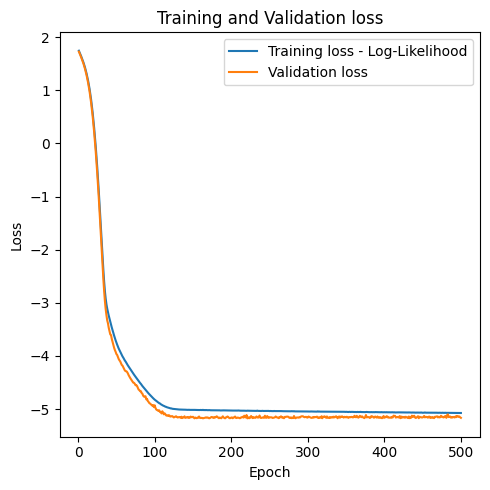

Evaluating MLP model for Fold 0...
Fold 0 Performance:
  MSE: 0.000495
  MAE: 0.015994
  R2: -0.024297

--- Aggregated Performance Metrics Across All Folds ---
Mean MSE: 0.000495
Mean MAE: 0.015994
Aggregated R2: -0.024297


In [ ]:
# Initialize lists to store performance metrics for aggregation
all_mse = []
all_mae = []
all_r2 = []
all_y_true = []
all_y_pred = []

# Iterate through each fold of the walk-forward dataloaders
for fold_num, (train_loader, test_loader) in enumerate(dataloaders):
    print(f"\n--- Training and Evaluating Fold {fold_num} ---")

    # Create a new instance of the MLPModel for each fold to ensure independent training
    # Use the input_size and sequence_length determined earlier
    mlp_model_fold = MLPModel(input_size, sequence_length, output_dim, dropout)

    # Train the model on the current fold's training data
    print(f"Training MLP model for Fold {fold_num}...")
    mlp_model_fold.fit(train_loader, val_loader=test_loader, epochs=500, lr=1e-5, verbose=True) # Set verbose to False to avoid printing loss for each epoch during walk-forward

    # Evaluate the model on the current fold's testing data
    print(f"Evaluating MLP model for Fold {fold_num}...")
    y_true_fold = torch.cat([y for _, y in test_loader], dim=0).numpy()
    y_pred_fold = mlp_model_fold.predict(test_loader)

    # Calculate performance metrics for the current fold
    mse_fold = mean_squared_error(y_true_fold, y_pred_fold)
    mae_fold = mean_absolute_error(y_true_fold, y_pred_fold)
    r2_fold = r2_score(y_true_fold, y_pred_fold)

    print(f"Fold {fold_num} Performance:")
    print(f"  MSE: {mse_fold:.6f}")
    print(f"  MAE: {mae_fold:.6f}")
    print(f"  R2: {r2_fold:.6f}")

    # Store metrics and predictions for aggregation
    all_mse.append(mse_fold)
    all_mae.append(mae_fold)
    all_r2.append(r2_fold)
    all_y_true.append(y_true_fold)
    all_y_pred.append(y_pred_fold)

# Aggregate performance metrics across all folds
print("\n--- Aggregated Performance Metrics Across All Folds ---")
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
print(f"Mean MSE: {mean_mse:.6f}")
print(f"Mean MAE: {mean_mae:.6f}")

# R2 calculated by concatenating all true and predicted values
aggregated_y_true = np.concatenate(all_y_true, axis=0)
aggregated_y_pred = np.concatenate(all_y_pred, axis=0)
aggregated_r2 = r2_score(aggregated_y_true, aggregated_y_pred)
print(f"Aggregated R2: {aggregated_r2:.6f}")

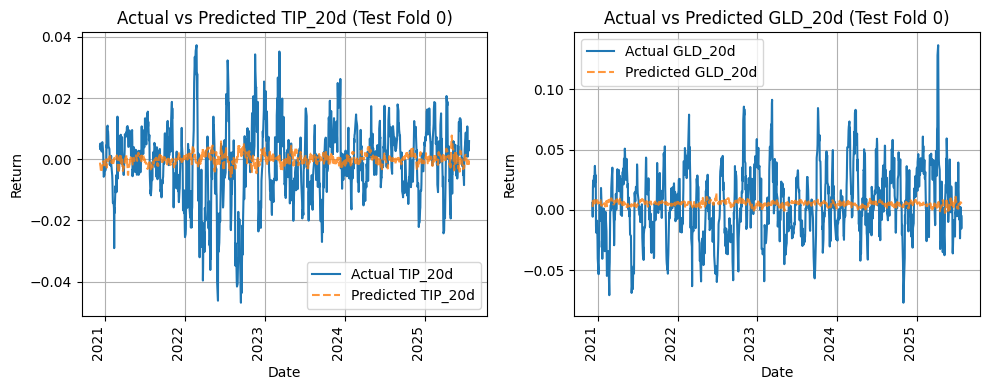

In [ ]:
# Iterate through each fold and plot predicted vs actual for test data
target_names = ['TIP_20d', 'GLD_20d']
n_folds = len(dataloaders)
n_targets = len(target_names)

current_i = 0
test_starts_in_df = []
# Need to use the length of the original data, which is len(df)
temp_i = 0
while temp_i + n_train + n_test <= len(df):
    train_start = temp_i
    train_end = temp_i + n_train
    test_start = train_end + purge
    test_end = test_start + n_test

    if test_end > len(df):
        break

    test_starts_in_df.append(test_start)
    temp_i = test_end + embargo

# Get the stored predictions from all_y_true and all_y_pred
test_lengths = [len(loader.dataset) for _, loader in dataloaders]

# Iterate through each fold and plot its test data in side-by-side subplots
for fold_num, (train_loader, test_loader) in enumerate(dataloaders):
    fig, axes = plt.subplots(nrows=1, ncols=n_targets, figsize=(5 * n_targets, 4), squeeze=False) # Create side-by-side subplots for each target, smaller size

    ax1 = axes[0, 0]
    ax2 = axes[0, 1]

    # Slice the aggregated true and predicted values for the current fold
    start_idx_in_aggregated = sum(test_lengths[:fold_num])
    end_idx_in_aggregated = start_idx_in_aggregated + test_lengths[fold_num]

    y_true_fold_aggregated = aggregated_y_true[start_idx_in_aggregated:end_idx_in_aggregated]
    y_pred_fold_aggregated = aggregated_y_pred[start_idx_in_aggregated:end_idx_in_aggregated]

    # Get the corresponding dates for this test fold
    test_start_in_df = test_starts_in_df[fold_num]
    test_dates_fold = df.index[test_start_in_df + seq_len - 1 : test_start_in_df + seq_len - 1 + len(y_true_fold_aggregated)]


    # Plot for the first target (TIP_20d)
    ax1.plot(test_dates_fold, y_true_fold_aggregated[:, 0], label=f'Actual {target_names[0]}', linewidth=1.5)
    ax1.plot(test_dates_fold, y_pred_fold_aggregated[:, 0], label=f'Predicted {target_names[0]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax1.set_title(f'Actual vs Predicted {target_names[0]} (Test Fold {fold_num})')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Return')
    ax1.legend()
    ax1.grid(True)
    plt.setp(ax1.get_xticklabels(), rotation=90, ha="right")


    # Plot for the second target (GLD_20d)
    ax2.plot(test_dates_fold, y_true_fold_aggregated[:, 1], label=f'Actual {target_names[1]}', linewidth=1.5)
    ax2.plot(test_dates_fold, y_pred_fold_aggregated[:, 1], label=f'Predicted {target_names[1]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax2.set_title(f'Actual vs Predicted {target_names[1]} (Test Fold {fold_num})')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Return')
    ax2.legend()
    ax2.grid(True)
    plt.setp(ax2.get_xticklabels(), rotation=90, ha="right")


    plt.tight_layout()
    plt.show()

### 3 LSTM Model and Results
The second model is a bidirectional LSTM neural networks with 2 hidden layers with dropouts followed by two linear layers with the last linear layer as the output layer containing 5 variables - the means, the volatilities and the correlation coefficient betwen the two assets. These 5 output variables are used as the parameters of a dynamic bi-variate Normal distribution. The loss function is the MSE measuring the distances between the prediction (mean of the Normal distribution) and the observed actual target variables, trained using Adam optimization with limited manual hyper-parameter tuning.

The out-of-sample performance of the LSTM model is very close to the MLP model, as shown by the MAE, MSE and R2 meaure. The actual against prediction plot shows the prediction seems to be flat - i.e. no clear patterns were found.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim=2,dropout=0.25, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.output_dim = output_dim

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)

        linear_input_size = hidden_size * 2 if bidirectional else hidden_size

        self.output_size = 5  # 2 means + 2 std + 1 correlation

        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, linear_input_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(linear_input_size // 2, self.output_size)
        )

    def forward(self, input_seq):
        num_directions = 2 if self.bidirectional else 1
        h_0 = torch.zeros(self.num_layers * num_directions, input_seq.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers * num_directions, input_seq.size(0), self.hidden_size)

        lstm_out, _ = self.lstm(input_seq, (h_0, c_0))
        last_step_out = lstm_out[:, -1, :]
        params = self.fc(last_step_out)

        mean = params[:, 0:self.output_dim]
        std_raw = params[:, self.output_dim:self.output_dim * 2]
        corr_raw = params[:, self.output_dim * 2]

        std = torch.exp(std_raw)
        corr = torch.tanh(corr_raw)

        cov11 = std[:, 0] ** 2
        cov22 = std[:, 1] ** 2
        cov12 = corr * std[:, 0] * std[:, 1]

        cov = torch.zeros((params.size(0), self.output_dim, self.output_dim))
        cov[:, 0, 0] = cov11
        cov[:, 1, 1] = cov22
        cov[:, 0, 1] = cov12
        cov[:, 1, 0] = cov12

        dist = MultivariateNormal(mean, covariance_matrix=cov)
        return dist

    def fit(self, train_loader, val_loader=None, epochs=100, lr=1e-4, verbose=True):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_losses, val_losses = [], []

        for epoch in range(1, epochs + 1):
            self.train()
            epoch_train_loss = 0.0
            for x, y in train_loader:
                optimizer.zero_grad()
                dist = self(x)
                loss = -dist.log_prob(y).mean()
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * x.size(0)
            train_losses.append(epoch_train_loss / len(train_loader.dataset))

            if val_loader is not None:
                self.eval()
                epoch_val_loss = 0.0
                with torch.no_grad():
                    for x, y in val_loader:
                        dist = self(x)
                        vloss = -dist.log_prob(y).mean()
                        epoch_val_loss += vloss.item() * x.size(0)
                val_losses.append(epoch_val_loss / len(val_loader.dataset))

                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}/{epochs} - Training loss: {train_losses[-1]:.4f} - Validation loss: {val_losses[-1]:.6f}")
            else:
                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}/{epochs} - Training loss: {train_losses[-1]:.4f}")

        if verbose:
            plt.figure(figsize=(5, 5))
            plt.plot(range(1, epochs + 1), train_losses, label='Training loss - Log-Likelihood')
            if val_loader is not None:
                plt.plot(range(1, epochs + 1), val_losses, label='Validation loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation loss')
            plt.legend()
            plt.tight_layout()
            plt.show()

    def predict(self, loader):
        self.eval()
        means = []
        with torch.no_grad():
            for x, _ in loader:
                dist = self(x)
                means.append(dist.mean.cpu().numpy())
        means = np.concatenate(means)
        return means

In [ ]:
input_size = dataloaders[0][0].dataset[0][0].shape[-1] # Features per time step from the last dimension of the input
sequence_length = dataloaders[0][0].dataset[0][0].shape[0] # Sequence length from the first dimension of the input
output_dim = dataloaders[0][0].dataset[0][1].shape[0] # Output size (number of targets)
hidden_size=30
num_layers=2
dropout=0.3
bidirectional=True

# Create an instance of the MLPModel
lstm_model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim, dropout=dropout, bidirectional=bidirectional)
print(lstm_model)

LSTMModel(
  (lstm): LSTM(2, 30, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=60, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=30, out_features=5, bias=True)
  )
)


The following showed the parameters and the model setup of the combined LSTM model.


--- Training and Evaluating LSTM Model for Fold 0 ---
Training LSTM model for Fold 0...
Epoch 10/300 - Training loss: -3.0303 - Validation loss: -3.544190
Epoch 20/300 - Training loss: -3.7027 - Validation loss: -4.076603
Epoch 30/300 - Training loss: -3.8368 - Validation loss: -4.232680
Epoch 40/300 - Training loss: -4.0176 - Validation loss: -4.345735
Epoch 50/300 - Training loss: -3.9736 - Validation loss: -4.358387
Epoch 60/300 - Training loss: -4.0532 - Validation loss: -4.342101
Epoch 70/300 - Training loss: -4.0366 - Validation loss: -4.493612
Epoch 80/300 - Training loss: -4.0978 - Validation loss: -4.375910
Epoch 90/300 - Training loss: -4.1046 - Validation loss: -4.495041
Epoch 100/300 - Training loss: -4.0986 - Validation loss: -4.513346
Epoch 110/300 - Training loss: -4.0751 - Validation loss: -4.476951
Epoch 120/300 - Training loss: -4.2105 - Validation loss: -4.466674
Epoch 130/300 - Training loss: -4.1131 - Validation loss: -4.532947
Epoch 140/300 - Training loss: -4.16

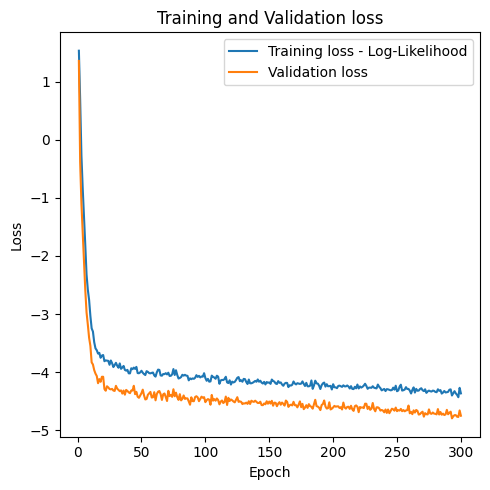

Evaluating LSTM model for Fold 0...
Fold 0 Performance:
  MSE: 0.000493
  MAE: 0.015856
  R2: -0.003632

--- Aggregated Performance Metrics Across All Folds (LSTM Model) ---
Mean MSE: 0.000493
Mean MAE: 0.015856
Aggregated R2 (on concatenated predictions): -0.003632


In [ ]:
# Initialize lists to store performance metrics for aggregation
all_mse_lstm = []
all_mae_lstm = []
all_r2_lstm = []
all_y_true_lstm = []
all_y_pred_lstm = []

# Iterate through each fold of the walk-forward dataloaders
for fold_num, (train_loader, test_loader) in enumerate(dataloaders):
    print(f"\n--- Training and Evaluating LSTM Model for Fold {fold_num} ---")

    # Create a new instance of the LSTMModel for each fold to ensure independent training
    lstm_model_fold = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim, dropout=dropout, bidirectional=bidirectional)

    # Train the model on the current fold's training data
    print(f"Training LSTM model for Fold {fold_num}...")
    # Use a smaller number of epochs for demonstration if full training is time consuming
    lstm_model_fold.fit(train_loader, val_loader=test_loader,epochs=300, lr=1e-4, verbose=True) # Set verbose to False for cleaner output during walk-forward

    # Evaluate the model on the current fold's testing data
    print(f"Evaluating LSTM model for Fold {fold_num}...")
    y_true_fold_lstm = torch.cat([y for _, y in test_loader], dim=0).numpy()
    y_pred_fold_lstm = lstm_model_fold.predict(test_loader)

    # Calculate performance metrics for the current fold
    mse_fold_lstm = mean_squared_error(y_true_fold_lstm, y_pred_fold_lstm)
    mae_fold_lstm = mean_absolute_error(y_true_fold_lstm, y_pred_fold_lstm)
    r2_fold_lstm = r2_score(y_true_fold_lstm, y_pred_fold_lstm)

    print(f"Fold {fold_num} Performance:")
    print(f"  MSE: {mse_fold_lstm:.6f}")
    print(f"  MAE: {mae_fold_lstm:.6f}")
    print(f"  R2: {r2_fold_lstm:.6f}")

    # Store metrics and predictions for aggregation
    all_mse_lstm.append(mse_fold_lstm)
    all_mae_lstm.append(mae_fold_lstm)
    all_r2_lstm.append(r2_fold_lstm)
    all_y_true_lstm.append(y_true_fold_lstm)
    all_y_pred_lstm.append(y_pred_fold_lstm)

# Aggregate performance metrics across all folds
print("\n--- Aggregated Performance Metrics Across All Folds (LSTM Model) ---")
mean_mse_lstm = np.mean(all_mse_lstm)
mean_mae_lstm = np.mean(all_mae_lstm)

print(f"Mean MSE: {mean_mse_lstm:.6f}")
print(f"Mean MAE: {mean_mae_lstm:.6f}")

# Aggregated R2 calculation
aggregated_y_true_lstm = np.concatenate(all_y_true_lstm, axis=0)
aggregated_y_pred_lstm = np.concatenate(all_y_pred_lstm, axis=0)
aggregated_r2_lstm = r2_score(aggregated_y_true_lstm, aggregated_y_pred_lstm)
print(f"Aggregated R2 (on concatenated predictions): {aggregated_r2_lstm:.6f}")

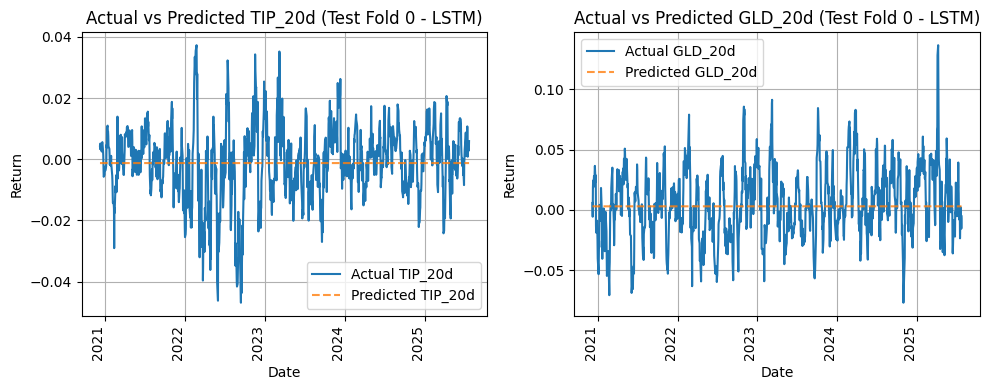

In [ ]:
target_names = ['TIP_20d', 'GLD_20d']
n_folds = len(dataloaders)
n_targets = len(target_names)

current_i = 0
test_starts_in_df = []
# Need to use the length of the original data, which is len(df)
temp_i = 0
while temp_i + n_train + n_test <= len(df):
    train_start = temp_i
    train_end = temp_i + n_train
    test_start = train_end + purge
    test_end = test_start + n_test

    if test_end > len(df):
        break

    test_starts_in_df.append(test_start)
    temp_i = test_end + embargo

# Get the stored predictions from all_y_true_lstm and all_y_pred_lstm
test_lengths = [len(loader.dataset) for _, loader in dataloaders]

# Iterate through each fold and plot its test data in side-by-side subplots
for fold_num, (train_loader, test_loader) in enumerate(dataloaders):
    fig, axes = plt.subplots(nrows=1, ncols=n_targets, figsize=(5 * n_targets, 4), squeeze=False) # Create side-by-side subplots for each target, smaller size

    ax1 = axes[0, 0] #
    ax2 = axes[0, 1] #


    # Slice the aggregated true and predicted values for the current fold
    start_idx_in_aggregated = sum(test_lengths[:fold_num])
    end_idx_in_aggregated = start_idx_in_aggregated + test_lengths[fold_num]

    y_true_fold_aggregated = aggregated_y_true_lstm[start_idx_in_aggregated:end_idx_in_aggregated]
    y_pred_fold_aggregated = aggregated_y_pred_lstm[start_idx_in_aggregated:end_idx_in_aggregated]

    # Get the corresponding dates for this test fold
    test_start_in_df = test_starts_in_df[fold_num]
    test_dates_fold = df.index[test_start_in_df + seq_len - 1 : test_start_in_df + seq_len - 1 + len(y_true_fold_aggregated)]


    # Plot for the first target (TIP_20d)
    ax1.plot(test_dates_fold, y_true_fold_aggregated[:, 0], label=f'Actual {target_names[0]}', linewidth=1.5)
    ax1.plot(test_dates_fold, y_pred_fold_aggregated[:, 0], label=f'Predicted {target_names[0]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax1.set_title(f'Actual vs Predicted {target_names[0]} (Test Fold {fold_num} - LSTM)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Return')
    ax1.legend()
    ax1.grid(True)
    plt.setp(ax1.get_xticklabels(), rotation=90, ha="right") # Make x-axis labels vertical


    # Plot for the second target (GLD_20d)
    ax2.plot(test_dates_fold, y_true_fold_aggregated[:, 1], label=f'Actual {target_names[1]}', linewidth=1.5)
    ax2.plot(test_dates_fold, y_pred_fold_aggregated[:, 1], label=f'Predicted {target_names[1]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax2.set_title(f'Actual vs Predicted {target_names[1]} (Test Fold {fold_num} - LSTM)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Return')
    ax2.legend()
    ax2.grid(True)
    plt.setp(ax2.get_xticklabels(), rotation=90, ha="right") # Make x-axis labels vertical


    plt.tight_layout()
    plt.show()

### 4 CNN (2D) Model and Result
The third model is a 2D CNN neural networks with 3 convolutional  layers with dropouts, batch normalization, ReLu activation and maxpooling. This is followed by two linear layers with the last linear layer as the output layer containing 5 variables - the means, the volatilities and the correlation coefficient betwen the two assets. These 5 output variables are used as the parameters of a dynamic bi-variate Normal distribution. The loss function is the MSE measuring the distances between the prediction (mean of the Normal distribution) and the observed actual target variables, trained based on the GAF transformed data, using Adam optimization with limited manual hyper-parameter tuning.

The out-of-sample performance of the CNN model sppears to be worse than the MLP and LSTM model, but it is not conclusive.

In [ ]:
class CNNModel(nn.Module): # Renamed from CNNModule to CNNModel for consistency
    def __init__(self, input_channels, image_size, output_dim=2, dropout=0.25):
        super().__init__()
        self.output_dim = output_dim
        self.image_size = image_size
        self.input_channels = input_channels

        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1), nn.Dropout2d(dropout), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),nn.Dropout2d(dropout), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.Dropout2d(dropout),nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.head = nn.Sequential(
            nn.Flatten(), # Flatten the output from conv layers
            nn.Linear(128, 32), # Adjusted input size based on conv output
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(32, self.output_dim * 2 + 1) # Output parameters for MultivariateNormal
        )

    def forward(self, x):
        # x shape: (batch_size, input_channels, image_size, image_size)
        x = self.conv(x)
        params = self.head(x)

        mean = params[:, 0:self.output_dim]
        std_raw = params[:, self.output_dim:self.output_dim * 2]
        corr_raw = params[:, self.output_dim * 2]

        std = torch.exp(std_raw)
        corr = torch.tanh(corr_raw)

        cov11 = std[:, 0] ** 2
        cov22 = std[:, 1] ** 2
        cov12 = corr * std[:, 0] * std[:, 1]

        cov = torch.zeros((params.size(0), self.output_dim, self.output_dim))
        cov[:, 0, 0] = cov11
        cov[:, 1, 1] = cov22
        cov[:, 0, 1] = cov12
        cov[:, 1, 0] = cov12

        dist = MultivariateNormal(mean, covariance_matrix=cov)
        return dist

    def fit(self, train_loader, val_loader=None, epochs=100, lr=1e-4, verbose=True):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_losses, val_losses = [], []

        for epoch in range(1, epochs + 1):
            self.train()
            epoch_train_loss = 0.0
            for x, y in train_loader:
                optimizer.zero_grad()
                dist = self(x)
                loss = -dist.log_prob(y).mean() # Negative log-likelihood
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * x.size(0)
            train_losses.append(epoch_train_loss / len(train_loader.dataset))

            if val_loader is not None:
                self.eval()
                epoch_val_loss = 0.0
                with torch.no_grad():
                    for x, y in val_loader:
                        dist = self(x)
                        vloss = -dist.log_prob(y).mean() # Negative log-likelihood
                        epoch_val_loss += vloss.item() * x.size(0)
                val_losses.append(epoch_val_loss / len(val_loader.dataset))

                if verbose and epoch % 10 == 0:
                    print(f"CNNModel Epoch {epoch}/{epochs} - Training loss: {train_losses[-1]:.4f} - Validation loss: {val_losses[-1]:.6f}")
            else:
                if verbose and epoch % 10 == 0:
                    print(f"CNNModel Epoch {epoch}/{epochs} - Training loss: {train_losses[-1]:.4f}")


        if verbose:
            plt.figure(figsize=(6,4))
            plt.plot(range(1, epochs+1), train_losses, label='Training loss - Log-Likelihood')
            if val_loader is not None:
                 plt.plot(range(1, epochs+1), val_losses, label='Validation loss')
            plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('CNNModel Loss')
            plt.legend(); plt.tight_layout(); plt.show()

    def predict(self, loader):
        self.eval()
        means = []
        with torch.no_grad():
            for x, _ in loader:
                dist = self(x)
                means.append(dist.mean.cpu().numpy())
        means = np.concatenate(means)
        return means

In [ ]:
# Define CNNModel parameters
# Input channels will be the number of features
input_channels = gaf_dataloaders[0][0].dataset[0][0].shape[0] # Number of features from GAF input shape
image_size = gaf_dataloaders[0][0].dataset[0][0].shape[-1] # Image size (seq_len) from GAF input shape
output_dim = gaf_dataloaders[0][0].dataset[0][1].shape[0] # Output size (number of targets)
dropout = 0.2 # Dropout rate

# Create an instance of the CNNModel
cnn_model = CNNModel(input_channels, image_size, output_dim, dropout)
print(cnn_model)

CNNModel(
  (conv): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Dropout2d(p=0.2, inplace=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Dropout2d(p=0.2, inplace=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveAvgPool2d(output_size=(1, 1))


--- Training and Evaluating CNN Model for Fold 0 ---
Training CNN model for Fold 0...
CNNModel Epoch 10/400 - Training loss: -2.6913 - Validation loss: -2.740682
CNNModel Epoch 20/400 - Training loss: -3.5825 - Validation loss: -3.319042
CNNModel Epoch 30/400 - Training loss: -4.0299 - Validation loss: -3.458300
CNNModel Epoch 40/400 - Training loss: -4.1171 - Validation loss: -3.533233
CNNModel Epoch 50/400 - Training loss: -4.2751 - Validation loss: -3.747511
CNNModel Epoch 60/400 - Training loss: -4.3212 - Validation loss: -3.870584
CNNModel Epoch 70/400 - Training loss: -4.4123 - Validation loss: -3.858869
CNNModel Epoch 80/400 - Training loss: -4.4783 - Validation loss: -3.823480
CNNModel Epoch 90/400 - Training loss: -4.4658 - Validation loss: -4.042415
CNNModel Epoch 100/400 - Training loss: -4.5357 - Validation loss: -4.095613
CNNModel Epoch 110/400 - Training loss: -4.5826 - Validation loss: -4.205049
CNNModel Epoch 120/400 - Training loss: -4.5668 - Validation loss: -4.26914

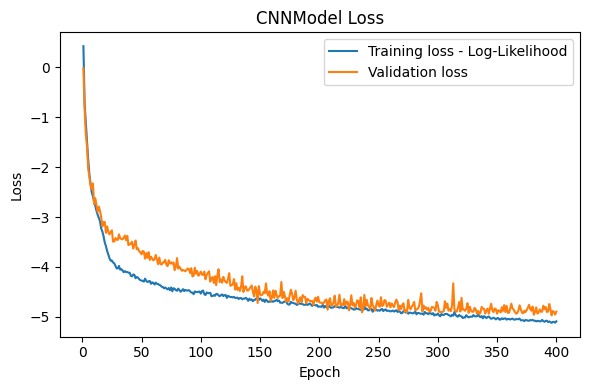

Evaluating CNN model for Fold 0...
Fold 0 Performance (CNN Model):
  MSE: 0.000494
  MAE: 0.016013
  R2: -0.045341

--- Aggregated Performance Metrics Across All Folds (CNN Model) ---
Mean MSE: 0.000494
Mean MAE: 0.016013
Aggregated R2 (on concatenated predictions): -0.045341


In [ ]:
# Initialize lists to store performance metrics for aggregation
all_mse_cnn = []
all_mae_cnn = []
all_r2_cnn = []
all_y_true_cnn = []
all_y_pred_cnn = []

# Iterate through each fold of the GAF walk-forward dataloaders
for fold_num, (train_loader_gaf, test_loader_gaf) in enumerate(gaf_dataloaders):
    print(f"\n--- Training and Evaluating CNN Model for Fold {fold_num} ---")

    # Create a new instance of the CNNModel for each fold
    # Use the input_channels, image_size, output_dim, and dropout determined earlier (cell ZoFfmP8yXb6g)
    cnn_model_fold = CNNModel(input_channels, image_size, output_dim, dropout)

    # Train the model on the current fold's GAF training data
    print(f"Training CNN model for Fold {fold_num}...")
    # You might need to adjust the number of epochs and learning rate for the CNN model
    cnn_model_fold.fit(train_loader_gaf, val_loader=test_loader_gaf, epochs=400, lr=1e-4, verbose=True) # Using fewer epochs for example

    # Evaluate the model on the current fold's GAF testing data
    print(f"Evaluating CNN model for Fold {fold_num}...")
    y_true_fold_cnn = torch.cat([y for _, y in test_loader_gaf], dim=0).numpy()
    y_pred_fold_cnn = cnn_model_fold.predict(test_loader_gaf)

    # Calculate performance metrics for the current fold
    mse_fold_cnn = mean_squared_error(y_true_fold_cnn, y_pred_fold_cnn)
    mae_fold_cnn = mean_absolute_error(y_true_fold_cnn, y_pred_fold_cnn)
    r2_fold_cnn = r2_score(y_true_fold_cnn, y_pred_fold_cnn)

    print(f"Fold {fold_num} Performance (CNN Model):")
    print(f"  MSE: {mse_fold_cnn:.6f}")
    print(f"  MAE: {mae_fold_cnn:.6f}")
    print(f"  R2: {r2_fold_cnn:.6f}")

    # Store metrics and predictions for aggregation
    all_mse_cnn.append(mse_fold_cnn)
    all_mae_cnn.append(mae_fold_cnn)
    all_r2_cnn.append(r2_fold_cnn)
    all_y_true_cnn.append(y_true_fold_cnn)
    all_y_pred_cnn.append(y_pred_fold_cnn)

# Aggregate performance metrics across all folds
print("\n--- Aggregated Performance Metrics Across All Folds (CNN Model) ---")
mean_mse_cnn = np.mean(all_mse_cnn)
mean_mae_cnn = np.mean(all_mae_cnn)

print(f"Mean MSE: {mean_mse_cnn:.6f}")
print(f"Mean MAE: {mean_mae_cnn:.6f}")

# Aggregated R2 calculation
aggregated_y_true_cnn = np.concatenate(all_y_true_cnn, axis=0)
aggregated_y_pred_cnn = np.concatenate(all_y_pred_cnn, axis=0)
aggregated_r2_cnn = r2_score(aggregated_y_true_cnn, aggregated_y_pred_cnn)
print(f"Aggregated R2 (on concatenated predictions): {aggregated_r2_cnn:.6f}")

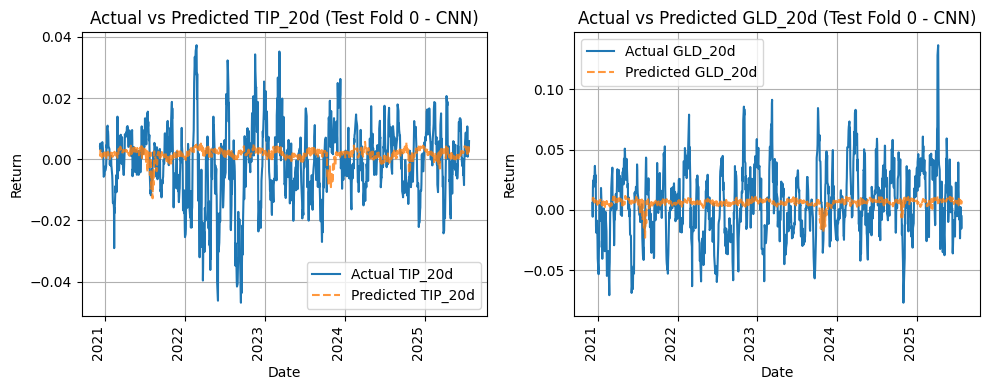

In [ ]:
# plot actual vs predicted for the CNN models
target_names = ['TIP_20d', 'GLD_20d'] # Assuming the order of targets in y is TIP_10d and GLD_10d
n_folds = len(gaf_dataloaders) # Use gaf_dataloaders for CNN
n_targets = len(target_names)

current_i = 0
test_starts_in_df = []
# Need to use the length of the original data, which is len(df)
temp_i = 0
while temp_i + n_train + n_test <= len(df):
    train_start = temp_i
    train_end = temp_i + n_train
    test_start = train_end + purge
    test_end = test_start + n_test

    if test_end > len(df):
        break

    test_starts_in_df.append(test_start)
    temp_i = test_end + embargo

# Get the stored predictions from all_y_true_cnn and all_y_pred_cnn
test_lengths_cnn = [len(loader.dataset) for _, loader in gaf_dataloaders] # Use gaf_dataloaders

# Iterate through each fold and plot its test data in side-by-side subplots
for fold_num, (train_loader_gaf, test_loader_gaf) in enumerate(gaf_dataloaders):
    fig, axes = plt.subplots(nrows=1, ncols=n_targets, figsize=(5 * n_targets, 4), squeeze=False) # Create side-by-side subplots for each target, smaller size

    ax1 = axes[0, 0]
    ax2 = axes[0, 1]


    # Slice the aggregated true and predicted values for the current fold
    start_idx_in_aggregated = sum(test_lengths_cnn[:fold_num])
    end_idx_in_aggregated = start_idx_in_aggregated + test_lengths_cnn[fold_num]

    y_true_fold_aggregated = aggregated_y_true_cnn[start_idx_in_aggregated:end_idx_in_aggregated]
    y_pred_fold_aggregated = aggregated_y_pred_cnn[start_idx_in_aggregated:end_idx_in_aggregated]

    # Get the corresponding dates for this test fold
    test_start_in_df = test_starts_in_df[fold_num]
    test_dates_fold = df.index[test_start_in_df + seq_len - 1 : test_start_in_df + seq_len - 1 + len(y_true_fold_aggregated)]


    # Plot for the first target (TIP_20d)
    ax1.plot(test_dates_fold, y_true_fold_aggregated[:, 0], label=f'Actual {target_names[0]}', linewidth=1.5)
    ax1.plot(test_dates_fold, y_pred_fold_aggregated[:, 0], label=f'Predicted {target_names[0]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax1.set_title(f'Actual vs Predicted {target_names[0]} (Test Fold {fold_num} - CNN)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Return')
    ax1.legend()
    ax1.grid(True)
    plt.setp(ax1.get_xticklabels(), rotation=90, ha="right") # Make x-axis labels vertical


    # Plot for the second target (GLD_20d)
    ax2.plot(test_dates_fold, y_true_fold_aggregated[:, 1], label=f'Actual {target_names[1]}', linewidth=1.5)
    ax2.plot(test_dates_fold, y_pred_fold_aggregated[:, 1], label=f'Predicted {target_names[1]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax2.set_title(f'Actual vs Predicted {target_names[1]} (Test Fold {fold_num} - CNN)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Return')
    ax2.legend()
    ax2.grid(True)
    plt.setp(ax2.get_xticklabels(), rotation=90, ha="right") # Make x-axis labels vertical


    plt.tight_layout()
    plt.show()

### 5 CNN (1D)
The last model is a 1D CNN neural networks with 3 convolutional layers with dropouts, batch normalization, ReLu activation and maxpooling. This is followed by two linear layers with the last linear layer as the output layer containing 5 variables - the means, the volatilities and the correlation coefficient betwen the two assets. These 5 output variables are used as the parameters of a dynamic bi-variate Normal distribution. The loss function is the MSE measuring the distances between the prediction (mean of the Normal distribution) and the observed actual target variables, trained based on the GAF transformed data, using Adam optimization with limited manual hyper-parameter tuning.

The out-of-sample performance of the 1D CNN model is comparable to models above, but the plot of actual against prediction seems to better.

In [ ]:
class CNN1DModel(nn.Module):
    def __init__(self, input_size, seq_len, output_dim=2, dropout=0.25):
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.output_dim = output_dim

        # Define 1D convolutional layers.
        # We will apply convolutions across the sequence length for each feature.
        # The input to the conv layers will be (batch_size, features, seq_len)
        self.conv = nn.Sequential(
            nn.Conv1d(input_size, 16, kernel_size=3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=4, dilation=4), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3,  padding=8, dilation=8), nn.BatchNorm1d(64), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling across the sequence dimension
        )

        # Head with two dense layers to output MultivariateNormal parameters
        self.head = nn.Sequential(
            nn.Flatten(), # Flatten the output from conv layers
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, self.output_dim * 2 + 1) # Output parameters for MultivariateNormal
        )

    def forward(self, x):
        """
        x: tensor of shape (batch_size, seq_len, features)
        Expected input for Conv1d is (batch_size, in_channels, seq_len)
        So, we need to permute the input.
        """
        # Permute input to (batch_size, features, seq_len) for Conv1d
        x = x.permute(0, 2, 1) # (batch_size, features, seq_len)

        features = self.conv(x)   # (batch_size, 128, 1) after AvgPool
        params = self.head(features) # (batch_size, output_dim * 2 + 1)

        mean = params[:, 0:self.output_dim]
        std_raw = params[:, self.output_dim:self.output_dim * 2]
        corr_raw = params[:, self.output_dim * 2]


        std = torch.exp(std_raw)
        corr = torch.tanh(corr_raw)

        # Ensure correlation is within valid range [-1 + epsilon, 1 - epsilon]
        # This helps numerical stability for small std values
        epsilon = 1e-6
        corr = torch.clamp(corr, -1. + epsilon, 1. - epsilon)

        cov11 = std[:, 0] ** 2
        cov22 = std[:, 1] ** 2
        cov12 = corr * std[:, 0] * std[:, 1]

        cov = torch.zeros((params.size(0), self.output_dim, self.output_dim))
        cov[:, 0, 0] = cov11
        cov[:, 1, 1] = cov22
        cov[:, 0, 1] = cov12
        cov[:, 1, 0] = cov12

        dist = MultivariateNormal(mean, covariance_matrix=cov)
        return dist

    def fit(self, train_loader, val_loader=None, epochs=100, lr=1e-4, verbose=True):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        train_losses, val_losses = [], []

        for epoch in range(1, epochs + 1):
            self.train()
            epoch_train_loss = 0.0
            for x, y in train_loader:
                optimizer.zero_grad()
                dist = self(x)
                loss = -dist.log_prob(y).mean() # Negative log-likelihood
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item() * x.size(0)
            train_losses.append(epoch_train_loss / len(train_loader.dataset))

            if val_loader is not None:
                self.eval()
                epoch_val_loss = 0.0
                with torch.no_grad():
                    for x, y in val_loader:
                        dist = self(x)
                        vloss = -dist.log_prob(y).mean() # Negative log-likelihood
                        epoch_val_loss += vloss.item() * x.size(0)
                val_losses.append(epoch_val_loss / len(val_loader.dataset))

                if verbose and epoch % 10 == 0:
                    print(f"CNN1DModel Epoch {epoch}/{epochs}: Training loss={train_losses[-1]:.6f}; Validation loss={val_losses[-1]:.6f}")
            else:
                if verbose and epoch % 10 == 0:
                    print(f"CNN1DModel Epoch {epoch}/{epochs}: Training loss={train_losses[-1]:.6f}")

        # Plot losses
        if verbose:
            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epochs+1), train_losses, label='Training loss - Log-Likelihood')
            if val_loader is not None:
                 plt.plot(range(1, epochs+1), val_losses, label='Validation loss')
            plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('CNN1DModel Loss')
            plt.legend(); plt.tight_layout(); plt.show()


    def predict(self, loader):
        self.eval()
        means = []
        with torch.no_grad():
            for x, _ in loader:
                dist = self(x)
                means.append(dist.mean.cpu().numpy())
        return np.concatenate(means)

In [ ]:
# Define CNN1DModel parameters
input_size_1d = dataloaders[0][0].dataset[0][0].shape[-1] # Features per time step
sequence_length_1d = dataloaders[0][0].dataset[0][0].shape[0] # Sequence length
output_dim_1d = dataloaders[0][0].dataset[0][1].shape[0] # Output size (number of targets)
dropout_1d = 0.25

# Create an instance of the CNN1DModel
cnn1d_model = CNN1DModel(input_size_1d, sequence_length_1d, output_dim_1d, dropout_1d)
print(cnn1d_model)

CNN1DModel(
  (conv): Sequential(
    (0): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): AdaptiveAvgPool1d(output_size=1)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)



--- Training and Evaluating CNN1D Model for Fold 0 ---
Training CNN1D model for Fold 0...
CNN1DModel Epoch 10/300: Training loss=-1.146745; Validation loss=-1.766924
CNN1DModel Epoch 20/300: Training loss=-2.731059; Validation loss=-3.117548
CNN1DModel Epoch 30/300: Training loss=-3.463487; Validation loss=-3.764174
CNN1DModel Epoch 40/300: Training loss=-3.976571; Validation loss=-4.174475
CNN1DModel Epoch 50/300: Training loss=-4.085835; Validation loss=-4.203037
CNN1DModel Epoch 60/300: Training loss=-4.189455; Validation loss=-4.227200
CNN1DModel Epoch 70/300: Training loss=-4.238042; Validation loss=-4.186790
CNN1DModel Epoch 80/300: Training loss=-4.310039; Validation loss=-4.524805
CNN1DModel Epoch 90/300: Training loss=-4.331111; Validation loss=-4.302654
CNN1DModel Epoch 100/300: Training loss=-4.414504; Validation loss=-4.612575
CNN1DModel Epoch 110/300: Training loss=-4.452572; Validation loss=-4.521769
CNN1DModel Epoch 120/300: Training loss=-4.447724; Validation loss=-4.4

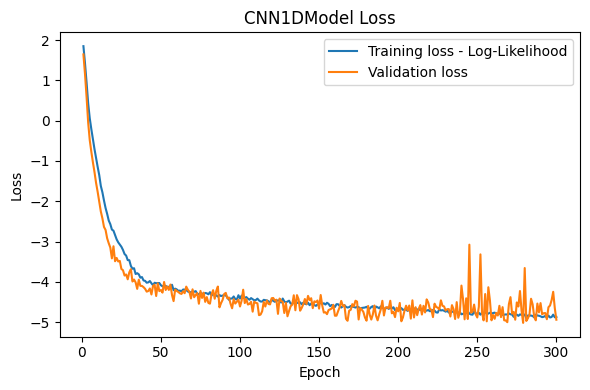

Evaluating CNN1D model for Fold 0...
Fold 0 Performance (CNN1D Model):
  MSE: 0.000591
  MAE: 0.017589
  R2: -0.208143

--- Aggregated Performance Metrics Across All Folds (CNN1D Model) ---
Mean MSE: 0.000591
Mean MAE: 0.017589
Aggregated R2 (on concatenated predictions): -0.208143


In [ ]:
# Initialize lists to store performance metrics for aggregation
all_mse_cnn1d = []
all_mae_cnn1d = []
all_r2_cnn1d = []
all_y_true_cnn1d = []
all_y_pred_cnn1d = []

# Iterate through each fold of the walk-forward dataloaders
for fold_num, (train_loader, test_loader) in enumerate(dataloaders):
    print(f"\n--- Training and Evaluating CNN1D Model for Fold {fold_num} ---")

    # Create a new instance of the CNN1DModel for each fold
    # Use the input_size_1d, sequence_length_1d, output_dim_1d, and dropout_1d determined earlier (cell 945c96b1)
    cnn1d_model_fold = CNN1DModel(input_size_1d, sequence_length_1d, output_dim_1d, dropout_1d)

    # Train the model on the current fold's training data
    print(f"Training CNN1D model for Fold {fold_num}...")
    # You might need to adjust the number of epochs and learning rate
    cnn1d_model_fold.fit(train_loader, val_loader=test_loader,epochs=300, lr=5e-5, verbose=True) # Using fewer epochs for example

    # Evaluate the model on the current fold's testing data
    print(f"Evaluating CNN1D model for Fold {fold_num}...")
    y_true_fold_cnn1d = torch.cat([y for _, y in test_loader], dim=0).numpy()
    y_pred_fold_cnn1d = cnn1d_model_fold.predict(test_loader)

    # Calculate performance metrics for the current fold
    mse_fold_cnn1d = mean_squared_error(y_true_fold_cnn1d, y_pred_fold_cnn1d)
    mae_fold_cnn1d = mean_absolute_error(y_true_fold_cnn1d, y_pred_fold_cnn1d)
    r2_fold_cnn1d = r2_score(y_true_fold_cnn1d, y_pred_fold_cnn1d)

    print(f"Fold {fold_num} Performance (CNN1D Model):")
    print(f"  MSE: {mse_fold_cnn1d:.6f}")
    print(f"  MAE: {mae_fold_cnn1d:.6f}")
    print(f"  R2: {r2_fold_cnn1d:.6f}")

    # Store metrics and predictions for aggregation
    all_mse_cnn1d.append(mse_fold_cnn1d)
    all_mae_cnn1d.append(mae_fold_cnn1d)
    all_r2_cnn1d.append(r2_fold_cnn1d)
    all_y_true_cnn1d.append(y_true_fold_cnn1d)
    all_y_pred_cnn1d.append(y_pred_fold_cnn1d)

# Aggregate performance metrics across all folds
print("\n--- Aggregated Performance Metrics Across All Folds (CNN1D Model) ---")
mean_mse_cnn1d = np.mean(all_mse_cnn1d)
mean_mae_cnn1d = np.mean(all_mae_cnn1d)
print(f"Mean MSE: {mean_mse_cnn1d:.6f}")
print(f"Mean MAE: {mean_mae_cnn1d:.6f}")

# Aggregated R2 calculation
aggregated_y_true_cnn1d = np.concatenate(all_y_true_cnn1d, axis=0)
aggregated_y_pred_cnn1d = np.concatenate(all_y_pred_cnn1d, axis=0)
aggregated_r2_cnn1d = r2_score(aggregated_y_true_cnn1d, aggregated_y_pred_cnn1d)
print(f"Aggregated R2 (on concatenated predictions): {aggregated_r2_cnn1d:.6f}")

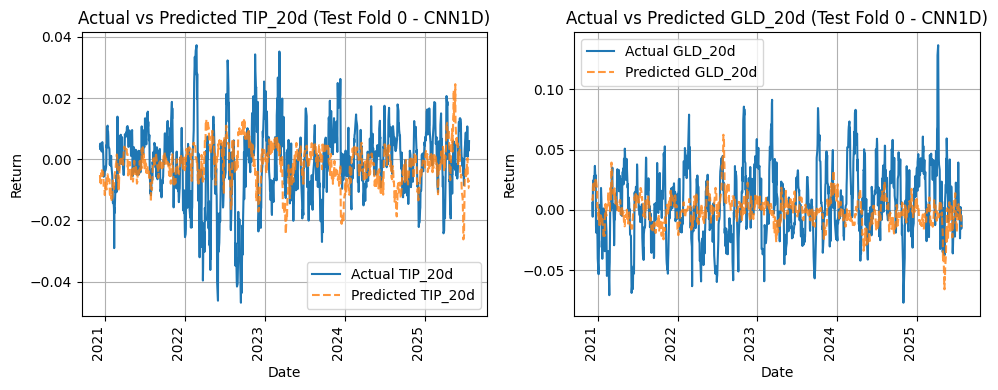

In [ ]:
# plot actual vs predicted for CNN1D models
target_names = ['TIP_20d', 'GLD_20d'] # Assuming the order of targets in y is TIP_10d and GLD_10d
n_folds = len(dataloaders) # Use dataloaders for CNN1D
n_targets = len(target_names)

current_i = 0
test_starts_in_df = []
# Need to use the length of the original data, which is len(df)
temp_i = 0
while temp_i + n_train + n_test <= len(df):
    train_start = temp_i
    train_end = temp_i + n_train
    test_start = train_end + purge
    test_end = test_start + n_test

    if test_end > len(df):
        break

    test_starts_in_df.append(test_start)
    temp_i = test_end + embargo

# Get the stored predictions from all_y_true_cnn1d and all_y_pred_cnn1d
test_lengths = [len(loader.dataset) for _, loader in dataloaders] # Use dataloaders for CNN1D

# Iterate through each fold and plot its test data in side-by-side subplots
for fold_num, (train_loader, test_loader) in enumerate(dataloaders):
    fig, axes = plt.subplots(nrows=1, ncols=n_targets, figsize=(5 * n_targets, 4), squeeze=False) # Create side-by-side subplots for each target, smaller size

    ax1 = axes[0, 0]
    ax2 = axes[0, 1]


    # Slice the aggregated true and predicted values for the current fold
    start_idx_in_aggregated = sum(test_lengths[:fold_num])
    end_idx_in_aggregated = start_idx_in_aggregated + test_lengths[fold_num]

    y_true_fold_aggregated = aggregated_y_true_cnn1d[start_idx_in_aggregated:end_idx_in_aggregated]
    y_pred_fold_aggregated = aggregated_y_pred_cnn1d[start_idx_in_aggregated:end_idx_in_aggregated]

    # Get the corresponding dates for this test fold
    test_start_in_df = test_starts_in_df[fold_num]
    test_dates_fold = df.index[test_start_in_df + seq_len - 1 : test_start_in_df + seq_len - 1 + len(y_true_fold_aggregated)]


    # Plot for the first target
    ax1.plot(test_dates_fold, y_true_fold_aggregated[:, 0], label=f'Actual {target_names[0]}', linewidth=1.5)
    ax1.plot(test_dates_fold, y_pred_fold_aggregated[:, 0], label=f'Predicted {target_names[0]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax1.set_title(f'Actual vs Predicted {target_names[0]} (Test Fold {fold_num} - CNN1D)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Return')
    ax1.legend()
    ax1.grid(True)
    plt.setp(ax1.get_xticklabels(), rotation=90, ha="right") # Make x-axis labels vertical


    # Plot for the second target
    ax2.plot(test_dates_fold, y_true_fold_aggregated[:, 1], label=f'Actual {target_names[1]}', linewidth=1.5)
    ax2.plot(test_dates_fold, y_pred_fold_aggregated[:, 1], label=f'Predicted {target_names[1]}', alpha=0.8, linewidth=1.5, linestyle='--')
    ax2.set_title(f'Actual vs Predicted {target_names[1]} (Test Fold {fold_num} - CNN1D)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Return')
    ax2.legend()
    ax2.grid(True)
    plt.setp(ax2.get_xticklabels(), rotation=90, ha="right") # Make x-axis labels vertical


    plt.tight_layout()
    plt.show()

### 6 Back-testing
We compared the portfolio strategy of dynamically rebalancing the weights for each asset using the MLP model outputs - means and covariances (from volatilities and correlation coefficent) to minimize the Sharpe Ratio. Please refer to this book chapter ["12.5.1 Computing the tangency portfolio"](https://bookdown.org/compfinezbook/introcompfinr/Efficient-portfolios-of.html) for the analytical optimal weigths of a multi-asset portfolio optimization problem.

The out-of-sample back-testing results show the the portfolio strategy based on the trained models are slightly better than the buy-and-hold strategy. Most importantly, the Sharpe ratio for the portfolio strategy are all higher than the buy-and-hold strategy with the LSTM model being the highest.

In [ ]:
# Calculate Sharpe Ratios for each strategy and the benchmark

# Define a function to calculate Sharpe Ratio
# Assuming a risk-free rate of 0 for simplicity
def calculate_sharpe_ratio(portfolio_values, annualizing_factor=252):
    """
    Calculates the annualized Sharpe Ratio assuming a risk-free rate of 0.

    Args:
        portfolio_values (pd.Series): Time series of portfolio values.
        annualizing_factor (int): Number of trading days in a year (for annualizing returns and volatility).

    Returns:
        float: Annualized Sharpe Ratio.
    """
    # Calculate daily returns
    daily_returns = portfolio_values.pct_change().dropna()

    if daily_returns.empty:
        return np.nan # Cannot calculate Sharpe Ratio if no returns

    # Calculate average daily return
    avg_daily_return = daily_returns.mean()

    # Calculate daily standard deviation of returns
    std_daily_return = daily_returns.std()

    # Annualize the average return and standard deviation
    annualized_return = avg_daily_return * annualizing_factor
    annualized_volatility = std_daily_return * np.sqrt(annualizing_factor)

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    # Avoid division by zero if volatility is zero
    if annualized_volatility == 0:
        return np.nan if annualized_return == 0 else np.inf * np.sign(annualized_return)
    else:
        sharpe_ratio = annualized_return / annualized_volatility
        return sharpe_ratio

# Assuming the portfolio value series variables (portfolio_value_mlp, portfolio_value_lstm,
# portfolio_value_cnn2d, portfolio_value_cnn1d, buy_and_hold_value) are available
# from the execution of cell jB-DMdGffU0L

print("\n--- Sharpe Ratios (Annualized, Risk-Free Rate = 0) ---")

sharpe_mlp = calculate_sharpe_ratio(portfolio_value_mlp)
print(f"MLP Strategy Sharpe Ratio: {sharpe_mlp:.4f}")

sharpe_lstm = calculate_sharpe_ratio(portfolio_value_lstm)
print(f"LSTM Strategy Sharpe Ratio: {sharpe_lstm:.4f}")

sharpe_cnn2d = calculate_sharpe_ratio(portfolio_value_cnn2d)
print(f"CNN (2D) Strategy Sharpe Ratio: {sharpe_cnn2d:.4f}")

sharpe_cnn1d = calculate_sharpe_ratio(portfolio_value_cnn1d)
print(f"CNN (1D) Strategy Sharpe Ratio: {sharpe_cnn1d:.4f}")

sharpe_bh = calculate_sharpe_ratio(buy_and_hold_value)
print(f"Buy-and-Hold Benchmark Sharpe Ratio: {sharpe_bh:.4f}")


--- Sharpe Ratios (Annualized, Risk-Free Rate = 0) ---
MLP Strategy Sharpe Ratio: 0.5167
LSTM Strategy Sharpe Ratio: 0.8716
CNN (2D) Strategy Sharpe Ratio: 0.8753
CNN (1D) Strategy Sharpe Ratio: 0.7528
Buy-and-Hold Benchmark Sharpe Ratio: 0.6312



--- Getting predictions from trained models for backtesting ---

Predicted distribution parameters obtained from existing trained models.
MLP parameters shape: (1161, 5)
LSTM parameters shape: (1161, 5)
CNN (2D) parameters shape: (1161, 5)
CNN (1D) parameters shape: (1161, 5)

Backtesting completed for all models and benchmark.

--- Cumulative Returns ---
MLP Strategy: 0.3179
LSTM Strategy: 0.7397
CNN (2D) Strategy: 0.5421
CNN (1D) Strategy: 0.5108
Buy-and-Hold Benchmark: 0.3134


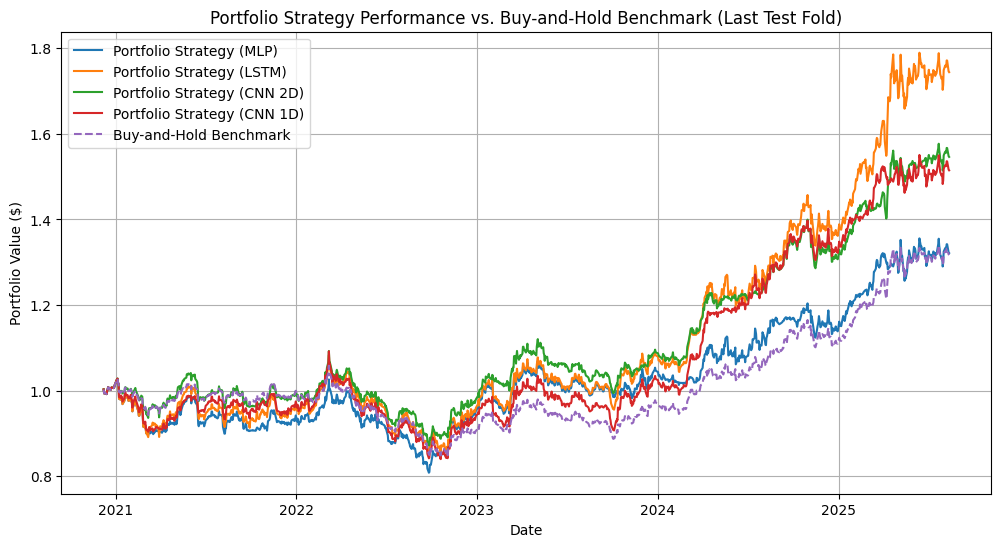

In [ ]:
# Define the function to calculate optimal weights for minimizing Sharpe Ratio
def calculate_optimal_weights_min_sharpe(expected_returns, cov_matrix):
    """
    Calculates the optimal portfolio weights to minimize Sharpe Ratio
    Formula: w = (Cov^-1 * E) / (1' * Cov^-1 * E), where E is the vector of expected returns,
    """
    # Ensure the covariance matrix is invertible and handle potential numerical issues
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix is singular. Using equal weights as a fallback.")
        n_assets = len(expected_returns)
        return np.ones(n_assets) / n_assets

    # Calculate the numerator: Cov^-1 * E
    numerator = np.dot(inv_cov_matrix, expected_returns)

    # Calculate the denominator: 1' * Cov^-1 * E
    # where 1 is a vector of ones with the same dimension as E
    vector_of_ones = np.ones_like(expected_returns)
    denominator = np.dot(vector_of_ones.T, numerator)

    # Calculate the optimal weights
    if np.abs(denominator) < 1e-8:
         print("Warning: Denominator in Sharpe Ratio weight calculation is close to zero. Using equal weights as a fallback.")
         n_assets = len(expected_returns)
         return np.ones(n_assets) / n_assets

    optimal_weights = numerator / denominator

    return optimal_weights

# Get last fold testing data and predictions from existing trained models

print("\n--- Getting predictions from trained models for backtesting ---")
# Get the last test fold data loaders
n_folds = len(dataloaders)
last_fold_num = n_folds - 1
_, last_test_loader = dataloaders[last_fold_num]
_, last_test_loader_gaf = gaf_dataloaders[last_fold_num]


# Simulate walkforward_loaders to get test_start index in original df for the last fold
current_i = 0
test_starts_in_df = []
temp_i = 0
while temp_i + n_train + n_test <= len(df):
    train_start = temp_i
    train_end = temp_i + n_train
    test_start = train_end + purge
    test_end = test_start + n_test

    if test_end > len(df):
        break

    test_starts_in_df.append(test_start)
    temp_i = test_end + embargo

last_test_start_in_df = test_starts_in_df[last_fold_num]

# Get the actual daily returns for the period covered by the last test fold's targets
last_test_prediction_dates = df.index[last_test_start_in_df + seq_len - 1 : last_test_start_in_df + seq_len - 1 + len(last_test_loader.dataset)]
# Start date for actual returns needed: one day after the first prediction date in the last test fold
actual_returns_start_date = last_test_prediction_dates[0] + pd.Timedelta(days=1)
# End date for actual returns needed: 20 days after the last prediction date in the last test fold for rebalancing
actual_returns_end_date = last_test_prediction_dates[-1] + pd.Timedelta(days=20)

# Get the actual daily returns for GLD and TIP for this period
actual_daily_returns_last_fold_period = df[['GLD', 'TIP']].loc[actual_returns_start_date : actual_returns_end_date].copy()


# Retrieve predictions from the models trained in the previous cells
try:
    def get_full_predictions(model, loader):
        model.eval()
        all_params = []
        with torch.no_grad():
            for x, _ in loader:
                dist = model(x)
                # Concatenate mean, log_std, and atanh_corr
                params = torch.cat([dist.mean, torch.log(dist.covariance_matrix.diagonal(dim1=-2, dim2=-1).sqrt()), torch.atanh(dist.covariance_matrix[:, 0, 1] / (dist.covariance_matrix.diagonal(dim1=-2, dim2=-1).sqrt()[:, 0] * dist.covariance_matrix.diagonal(dim1=-2, dim2=-1).sqrt()[:, 1] + 1e-8)).unsqueeze(1)], dim=1)
                all_params.append(params.cpu().numpy())
        return np.concatenate(all_params)

    predicted_params_mlp = get_full_predictions(mlp_model_fold, last_test_loader)
    predicted_params_lstm = get_full_predictions(lstm_model_fold, last_test_loader)
    predicted_params_cnn2d = get_full_predictions(cnn_model_fold, last_test_loader_gaf)
    predicted_params_cnn1d = get_full_predictions(cnn1d_model_fold, last_test_loader)

    print("\nPredicted distribution parameters obtained from existing trained models.")
    print(f"MLP parameters shape: {predicted_params_mlp.shape}")
    print(f"LSTM parameters shape: {predicted_params_lstm.shape}")
    print(f"CNN (2D) parameters shape: {predicted_params_cnn2d.shape}")
    print(f"CNN (1D) parameters shape: {predicted_params_cnn1d.shape}")

except NameError as e:
    print(f"Error: {e}")
    print("Please ensure the training cells for all models (MLP, LSTM, CNN 2D, CNN 1D)")
    print("have been successfully executed for the last fold before running backtesting.")
    raise # Re-raise the exception to stop execution if models are not found

# Implement backtesting strategy for each model
def run_backtest_strategy_sharpe_20d_rebalance(predicted_params, actual_daily_returns, prediction_dates, rebalance_period_trading_days=20, initial_investment=1.0):
    """
    Runs a portfolio strategy backtest minimizing Sharpe Ratio based on predicted distribution parameters.
    Rebalances every `rebalance_period_trading_days` trading days.
    """
    portfolio_value = pd.Series(index=actual_daily_returns.index, dtype=float)
    portfolio_value.iloc[0] = initial_investment

    # Map prediction dates to their index in the actual_daily_returns index for easier lookup
    prediction_start_indices = actual_daily_returns.index.searchsorted(prediction_dates + pd.Timedelta(days=1), side='left')

    current_weights = np.ones(predicted_params.shape[1] // 2) / (predicted_params.shape[1] // 2) # Start with equal weights for assets
    last_rebalance_idx = 0 # Index in actual_daily_returns where the last rebalancing occurred

    # Iterate through the actual daily returns index to apply daily returns
    for i in range(len(actual_daily_returns.index)):
        current_date = actual_daily_returns.index[i]

        # Check if it's time to rebalance (every `rebalance_period_trading_days`)
        if (i - last_rebalance_idx) % rebalance_period_trading_days == 0 and i > 0:
            # It's a rebalancing day. We need to use the most recent prediction available.
            most_recent_prediction_idx = prediction_dates.searchsorted(current_date, side='right') - 1

            if most_recent_prediction_idx >= 0:
                 # Use the parameters from the most recent prediction
                 predicted_mean = predicted_params[most_recent_prediction_idx, 0:2]
                 predicted_std = np.exp(predicted_params[most_recent_prediction_idx, 2:4])
                 predicted_corr = np.tanh(predicted_params[most_recent_prediction_idx, 4])

                 # Construct the predicted covariance matrix
                 predicted_cov_matrix = np.zeros((2, 2))
                 predicted_cov_matrix[0, 0] = predicted_std[0] ** 2
                 predicted_cov_matrix[1, 1] = predicted_std[1] ** 2
                 predicted_cov_matrix[0, 1] = predicted_corr * predicted_std[0] * predicted_std[1]
                 predicted_cov_matrix[1, 0] = predicted_cov_matrix[0, 1]

                 # Calculate optimal weights for the period
                 predicted_mean_for_sharpe = predicted_mean

                 current_weights = calculate_optimal_weights_min_sharpe(predicted_mean_for_sharpe, predicted_cov_matrix)

                 # Ensure weights sum to 1 and handle potential issues
                 if np.sum(current_weights) == 0:
                     current_weights = np.ones(2) / 2 # Fallback to equal weights
                     print(f"Warning: Optimal weights sum to zero for rebalance date {current_date}. Using equal weights.")
                 else:
                      current_weights = current_weights / np.sum(current_weights)

                 # Optional: Add constraint for no shorting (weights >= 0)
                 current_weights[current_weights < 0] = 0
                 if np.sum(current_weights) > 0:
                     current_weights = current_weights / np.sum(current_weights)
                 else:
                      current_weights = np.ones(2) / 2 # Fallback if all became zero

                 last_rebalance_idx = i # Update the last rebalance index

            else:
                 # If no prediction is available before or on the current date, maintain current weights (or fallback)
                 print(f"Warning: No prediction available for rebalance date {current_date}. Maintaining previous weights.")
                 # If this is the very first rebalance and no prediction is available, current_weights is still initial equal weights.

        # Get the portfolio value at the start of the day
        if i > 0:
            portfolio_value_start_of_day = portfolio_value.iloc[i-1]
        else:
            portfolio_value_start_of_day = initial_investment

        # Calculate daily portfolio return based on current weights and actual daily returns
        daily_asset_returns = actual_daily_returns.iloc[i].values
        daily_portfolio_return = np.dot(current_weights, daily_asset_returns)

        # Update portfolio value at the end of the day
        portfolio_value.iloc[i] = portfolio_value_start_of_day * (1 + daily_portfolio_return)

    # Fill in any missing values in portfolio_value (due to gaps) by carrying forward the last valid value
    portfolio_value.ffill(inplace=True)
    # Backfill any leading NaNs if the first period had no trading days
    portfolio_value.bfill(inplace=True)

    return portfolio_value


# Run backtesting for each model's predictions using the Sharpe Ratio minimization strategy
portfolio_value_mlp = run_backtest_strategy_sharpe_20d_rebalance(predicted_params_mlp, actual_daily_returns_last_fold_period, last_test_prediction_dates, rebalance_period_trading_days=20, initial_investment=1.0)
portfolio_value_lstm = run_backtest_strategy_sharpe_20d_rebalance(predicted_params_lstm, actual_daily_returns_last_fold_period, last_test_prediction_dates, rebalance_period_trading_days=20, initial_investment=1.0)
portfolio_value_cnn2d = run_backtest_strategy_sharpe_20d_rebalance(predicted_params_cnn2d, actual_daily_returns_last_fold_period, last_test_prediction_dates, rebalance_period_trading_days=20, initial_investment=1.0)
portfolio_value_cnn1d = run_backtest_strategy_sharpe_20d_rebalance(predicted_params_cnn1d, actual_daily_returns_last_fold_period, last_test_prediction_dates, rebalance_period_trading_days=20, initial_investment=1.0)

# buy-and-hold benchmark
initial_investment_bh = 1.0 # Match initial investment of strategies

buy_and_hold_value = pd.Series(index=actual_daily_returns_last_fold_period.index, dtype=float)
buy_and_hold_value.iloc[0] = initial_investment_bh

# Initial investment split equally
initial_asset_value = initial_investment_bh / 2.0

# Calculate the value of each asset over time
asset_values = initial_asset_value * (1 + actual_daily_returns_last_fold_period).cumprod()

# The total buy-and-hold portfolio value is the sum of the values of each asset
buy_and_hold_value = asset_values.sum(axis=1)

print("\nBacktesting completed for all models and benchmark.")

# compare performance
# Calculate Cumulative Returns
cumulative_return_mlp = (portfolio_value_mlp.iloc[-1] / portfolio_value_mlp.iloc[0]) - 1
cumulative_return_lstm = (portfolio_value_lstm.iloc[-1] / portfolio_value_lstm.iloc[0]) - 1
cumulative_return_cnn2d = (portfolio_value_cnn2d.iloc[-1] / portfolio_value_cnn2d.iloc[0]) - 1
cumulative_return_cnn1d = (portfolio_value_cnn1d.iloc[-1] / portfolio_value_cnn1d.iloc[0]) - 1
cumulative_return_bh = (buy_and_hold_value.iloc[-1] / buy_and_hold_value.iloc[0]) - 1

print("\n--- Cumulative Returns ---")
print(f"MLP Strategy: {cumulative_return_mlp:.4f}")
print(f"LSTM Strategy: {cumulative_return_lstm:.4f}")
print(f"CNN (2D) Strategy: {cumulative_return_cnn2d:.4f}")
print(f"CNN (1D) Strategy: {cumulative_return_cnn1d:.4f}")
print(f"Buy-and-Hold Benchmark: {cumulative_return_bh:.4f}")

# plot Portfolio Values
plt.figure(figsize=(12, 6))

plt.plot(portfolio_value_mlp.index, portfolio_value_mlp, label='Portfolio Strategy (MLP)')
plt.plot(portfolio_value_lstm.index, portfolio_value_lstm, label='Portfolio Strategy (LSTM)')
plt.plot(portfolio_value_cnn2d.index, portfolio_value_cnn2d, label='Portfolio Strategy (CNN 2D)')
plt.plot(portfolio_value_cnn1d.index, portfolio_value_cnn1d, label='Portfolio Strategy (CNN 1D)')
plt.plot(buy_and_hold_value.index, buy_and_hold_value, label='Buy-and-Hold Benchmark', linestyle='--')

plt.title('Portfolio Strategy Performance vs. Buy-and-Hold Benchmark (Last Test Fold)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

### Checking the dynamic latent Normal distribution

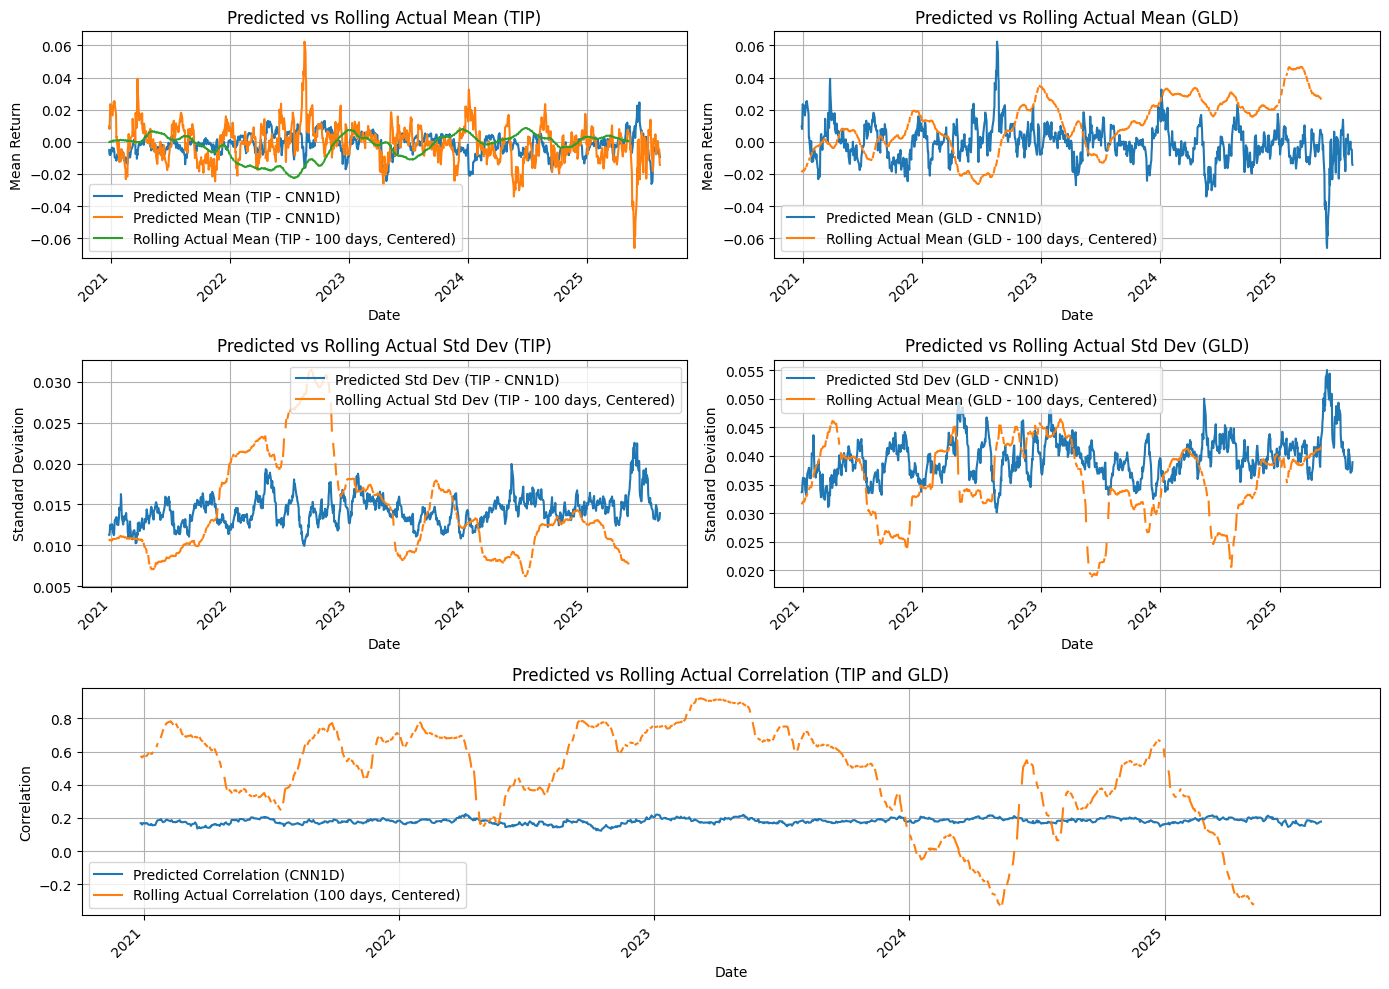

In [ ]:
# Collect the CNN1D model's predicted means, volatilities, and correlations on the testing data
predicted_means_cnn1d = predicted_params_cnn1d[:, 0:2]
predicted_stds_cnn1d = np.exp(predicted_params_cnn1d[:, 2:4])
predicted_corrs_cnn1d = np.tanh(predicted_params_cnn1d[:, 4])

# Need the dates for the predicted values to align with the actual rolling metrics
predicted_dates_cnn1d = last_test_prediction_dates # These are the dates the predictions were made for

# Calculate Rolling Actuals (50 days before and 50 days after)
start_idx_rolling = max(0, df.index.searchsorted(predicted_dates_cnn1d[0], side='left') - 50)
earliest_date_needed_for_rolling = df.index[start_idx_rolling]

# End 50 trading days after the last prediction date
end_idx_rolling = min(len(df) - 1, df.index.searchsorted(predicted_dates_cnn1d[-1], side='right') + 50)
latest_date_needed_for_rolling = df.index[end_idx_rolling]

# Get the actual daily returns for this extended period
extended_daily_returns = df[['GLD', 'TIP']].loc[earliest_date_needed_for_rolling : latest_date_needed_for_rolling].copy()

# Calculate the actual 20-day cumulative returns for this extended period
extended_daily_returns['TIP_20d_actual'] = extended_daily_returns['TIP'].rolling(20).apply(lambda x: np.prod(x + 1) - 1).shift(-20)
extended_daily_returns['GLD_20d_actual'] = extended_daily_returns['GLD'].rolling(20).apply(lambda x: np.prod(x + 1) - 1).shift(-20)
extended_daily_returns.dropna(inplace=True)


# Calculate the 100-day rolling mean, std, and correlation on these extended 20-day cumulative returns.
rolling_window = 100
# Centered rolling window: min_periods = window // 2, center=True
rolling_mean_tip_actual_20d_extended = extended_daily_returns['TIP_20d_actual'].rolling(window=rolling_window, center=True).mean()
rolling_mean_gld_actual_20d_extended = extended_daily_returns['GLD_20d_actual'].rolling(window=rolling_window, center=True).mean()

rolling_std_tip_actual_20d_extended = extended_daily_returns['TIP_20d_actual'].rolling(window=rolling_window, center=True).std()
rolling_std_gld_actual_20d_extended = extended_daily_returns['GLD_20d_actual'].rolling(window=rolling_window, center=True).std()

rolling_correlation_actual_20d_extended = extended_daily_returns['TIP_20d_actual'].rolling(window=rolling_window, center=True).corr(extended_daily_returns['GLD_20d_actual'])

# Create dates for the end of the predicted periods
predicted_end_dates = predicted_dates_cnn1d + pd.Timedelta(days=20)

# Select the rolling actuals that correspond to these predicted end dates
rolling_mean_tip_actual_20d_aligned = rolling_mean_tip_actual_20d_extended.reindex(predicted_end_dates)
rolling_mean_gld_actual_20d_aligned = rolling_mean_gld_actual_20d_extended.reindex(predicted_end_dates)
rolling_std_tip_actual_20d_aligned = rolling_std_tip_actual_20d_extended.reindex(predicted_end_dates)
rolling_std_gld_actual_20d_aligned = rolling_std_gld_actual_20d_extended.reindex(predicted_end_dates)
rolling_correlation_actual_20d_aligned = rolling_correlation_actual_20d_extended.reindex(predicted_end_dates)

# The common dates for plotting are now the predicted end dates
common_dates = predicted_end_dates # Use the predicted end dates for the x-axis

# Plotting the comparison
plt.figure(figsize=(14, 10))

# Plot Predicted vs Rolling Actual Mean (TIP)
plt.subplot(3, 2, 1)
plt.plot(common_dates, predicted_means_cnn1d, label='Predicted Mean (TIP - CNN1D)') # Use original predicted_means aligned by date
plt.plot(common_dates, rolling_mean_tip_actual_20d_aligned, label='Rolling Actual Mean (TIP - 100 days, Centered)')
plt.title('Predicted vs Rolling Actual Mean (TIP)')
plt.xlabel('Date')
plt.ylabel('Mean Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')


# Plot Predicted vs Rolling Actual Mean (GLD)
plt.subplot(3, 2, 2)
plt.plot(common_dates, predicted_means_cnn1d[:, 1], label='Predicted Mean (GLD - CNN1D)') # Use original predicted_means aligned by date
plt.plot(common_dates, rolling_mean_gld_actual_20d_aligned, label='Rolling Actual Mean (GLD - 100 days, Centered)')
plt.title('Predicted vs Rolling Actual Mean (GLD)')
plt.xlabel('Date')
plt.ylabel('Mean Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')

# Plot Predicted vs Rolling Actual Std Dev (TIP)
plt.subplot(3, 2, 3)
plt.plot(common_dates, predicted_stds_cnn1d[:, 0], label='Predicted Std Dev (TIP - CNN1D)') # Use original predicted_stds aligned by date
plt.plot(common_dates, rolling_std_tip_actual_20d_aligned, label='Rolling Actual Std Dev (TIP - 100 days, Centered)')
plt.title('Predicted vs Rolling Actual Std Dev (TIP)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')

# Plot Predicted vs Rolling Actual Std Dev (GLD)
plt.subplot(3, 2, 4)
plt.plot(common_dates, predicted_stds_cnn1d[:, 1], label='Predicted Std Dev (GLD - CNN1D)') # Use original predicted_stds aligned by date
plt.plot(common_dates, rolling_std_gld_actual_20d_aligned, label='Rolling Actual Mean (GLD - 100 days, Centered)')
plt.title('Predicted vs Rolling Actual Std Dev (GLD)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')

# Plot Predicted vs Rolling Actual Correlation
plt.subplot(3, 1, 3) # Span across two columns
plt.plot(common_dates, predicted_corrs_cnn1d, label='Predicted Correlation (CNN1D)') # Use original predicted_corrs aligned by date
plt.plot(common_dates, rolling_correlation_actual_20d_aligned, label='Rolling Actual Correlation (100 days, Centered)')
plt.title('Predicted vs Rolling Actual Correlation (TIP and GLD)')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()

### Reference

*"12.5.1 Computing the tangency portfolio using matrix algebra." An Introduction to Computational Finance with R, bookdown.org*